# Session 2 Chamodi : Gait Analysis
### Time : 2025-05-31 21:44:45.469000 to 2025-05-31 21:45:25.529000
### Sensor ID : 601
### Steps : 30

## Fetching Raw Data from DynamoDB

In [82]:
import sys
import os
from datetime import datetime

# Append app to sys.path to access modules like app.utils.dynamo
sys.path.append(os.path.abspath("../app"))

In [83]:
from utils.dynamo import fetch_session_data

In [84]:
sensor_id = 601
start_time = datetime.fromisoformat("2025-05-31 23:09:16.722000")
end_time = datetime.fromisoformat("2025-05-31 23:09:40.685000")

data = fetch_session_data(sensor_id, start_time, end_time)
print(f"📦 Retrieved {len(data)} records")



🔍 [DEBUG] Fetching data for Sensor ID: 601
🕒 [DEBUG] Start Time: 2025-05-31 23:09:16.722000 -> 1748713156722
🕒 [DEBUG] End Time:   2025-05-31 23:09:40.685000 -> 1748713180685
📦 [DEBUG] Retrieved 238 items from DynamoDB.

📦 Retrieved 238 records


In [ ]:
data

## Step 1 :  Preprocess and Sort

### Sort By Timestamp

In [86]:
import pandas as pd
from decimal import Decimal

# Convert to DataFrame
df = pd.json_normalize(data)

# Convert all Decimal values to float (optional but useful)
df = df.map(lambda x: float(x) if isinstance(x, Decimal) else x)

# Sort by timestamp
df = df.sort_values(by="timestamp").reset_index(drop=True)

# Show first few rows
df.head()


gyro_cal  mag_cal   roll         type  FSR_12  FSR_11  FSR_10  FSR_16  \
0       3.0      3.0 -99.00  sensor_data  1792.0     0.0  1162.0  1438.0   
1       3.0      3.0 -98.25  sensor_data  1269.0     0.0     0.0   783.0   
2       3.0      3.0 -97.37  sensor_data     0.0     0.0     0.0     0.0   
3       3.0      3.0 -96.25  sensor_data     0.0     0.0     0.0     0.0   
4       3.0      3.0 -94.94  sensor_data     0.0     0.0     0.0     0.0   

   FSR_15  FSR_1  ...  device_id    yaw     gx     gy     gz  sys_cal  \
0   746.0    0.0  ...        601 -26.12  -5.31  -3.44 -12.44      3.0   
1    17.0    0.0  ...        601 -25.06  -7.00 -11.94   1.25      3.0   
2    68.0    0.0  ...        601 -25.12  -8.94  -4.37   7.56      3.0   
3    39.0    0.0  ...        601 -24.50 -12.19  -9.44  -2.75      3.0   
4    77.0    0.0  ...        601 -22.44 -10.50  -5.19 -14.87      3.0   

   accel_cal    ax    ay    az  
0        3.0  0.40  0.06 -0.17  
1        3.0  0.17 -0.02  0.09  
2        3.0 -0.05  0.21  0.19  
3        3.0  0.42  0.28  0.18  
4        3.0  0.15 -0.21  0.36  

[5 rows x 36 columns]

### Check for Missing FSR Values

In [87]:
required_fsrs = [f"FSR_{i}" for i in range(1, 17)]
missing = [col for col in required_fsrs if col not in df.columns]
print("Missing FSR columns:", missing)

Missing FSR columns: []


### Clipping FSR values (0 to 4095)

In [88]:
for col in required_fsrs:
    df[col] = df[col].clip(0, 4095)


### Normalizing  Timestamps 

In [89]:
df["time_sec"] = df["timestamp"] - df["timestamp"].min()

### Replacing FSR_14 values with FSR_11

FSR_14 continously High since it is connected to GPIO 0

In [90]:
df["FSR_14"] = df["FSR_11"]

## Step 2: Plotting Raw Sensor Readings

### FSR Readings

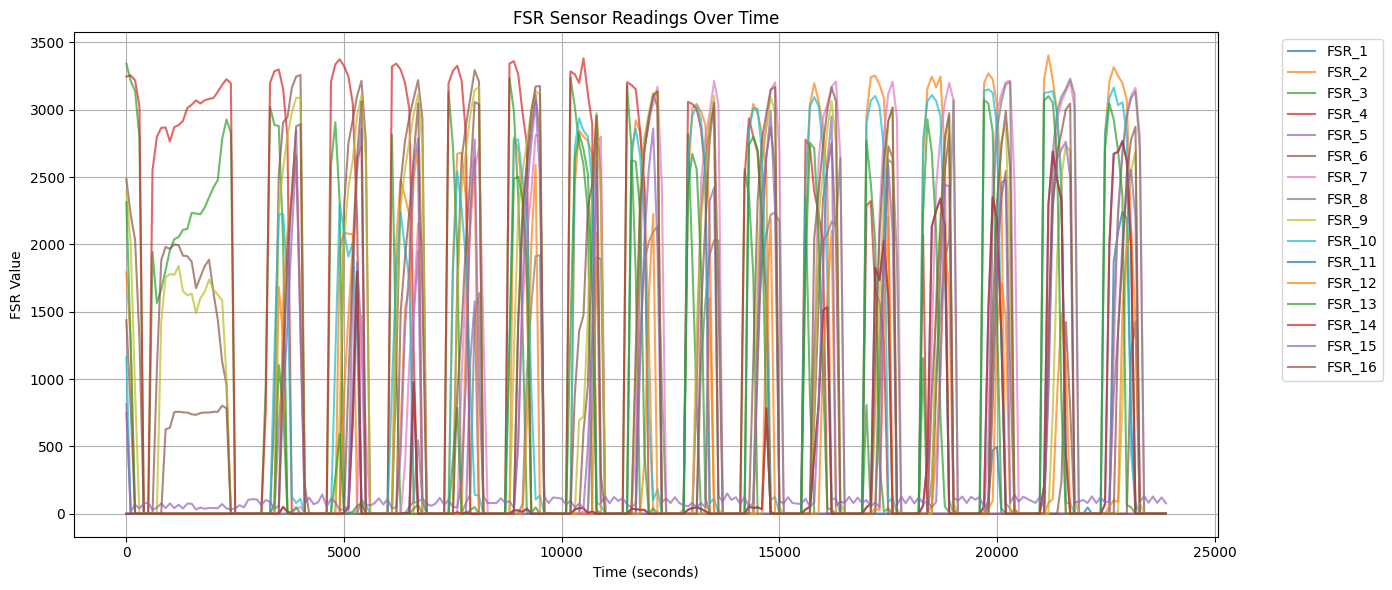

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

for i in range(1, 17):
    plt.plot(df["time_sec"], df[f"FSR_{i}"], label=f"FSR_{i}", alpha=0.7)

plt.xlabel("Time (seconds)")
plt.ylabel("FSR Value")
plt.title("FSR Sensor Readings Over Time")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)
plt.tight_layout()
plt.grid(True)
plt.show()


### Accelrometer Readings

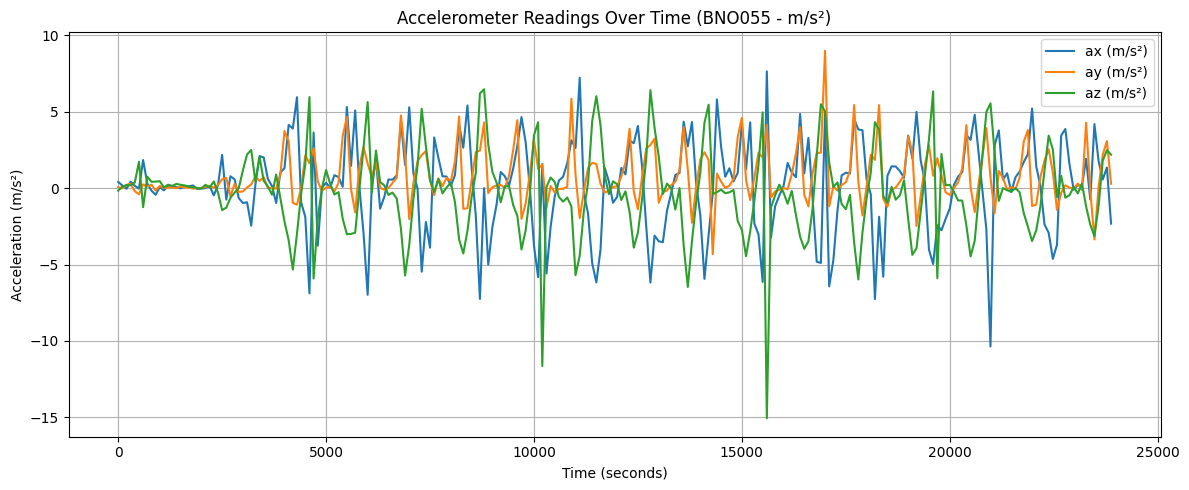

In [92]:
plt.figure(figsize=(12, 5))

plt.plot(df["time_sec"], df["ax"], label="ax (m/s²)")
plt.plot(df["time_sec"], df["ay"], label="ay (m/s²)")
plt.plot(df["time_sec"], df["az"], label="az (m/s²)")

plt.title("Accelerometer Readings Over Time (BNO055 - m/s²)")
plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration (m/s²)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Gyroscope Readings

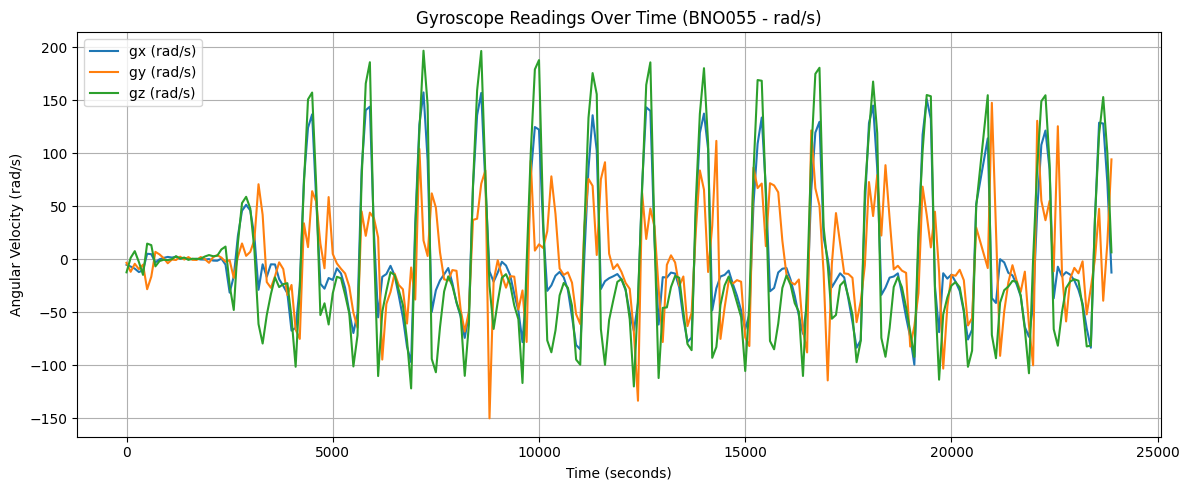

In [93]:
plt.figure(figsize=(12, 5))

plt.plot(df["time_sec"], df["gx"], label="gx (rad/s)")
plt.plot(df["time_sec"], df["gy"], label="gy (rad/s)")
plt.plot(df["time_sec"], df["gz"], label="gz (rad/s)")

plt.title("Gyroscope Readings Over Time (BNO055 - rad/s)")
plt.xlabel("Time (seconds)")
plt.ylabel("Angular Velocity (rad/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Yaw Pitch Role Raw Readings

In [94]:
plt.figure(figsize=(12, 5))

plt.plot(df["time_sec"], df["yaw"], label="Yaw (°)")
plt.plot(df["time_sec"], df["pitch"], label="Pitch (°)")
plt.plot(df["time_sec"], df["roll"], label="Roll (°)")

plt.title("Euler Angles Over Time (Yaw, Pitch, Roll)")
plt.xlabel("Time (seconds)")
plt.ylabel("Angle (degrees)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Raw Quternions Readings

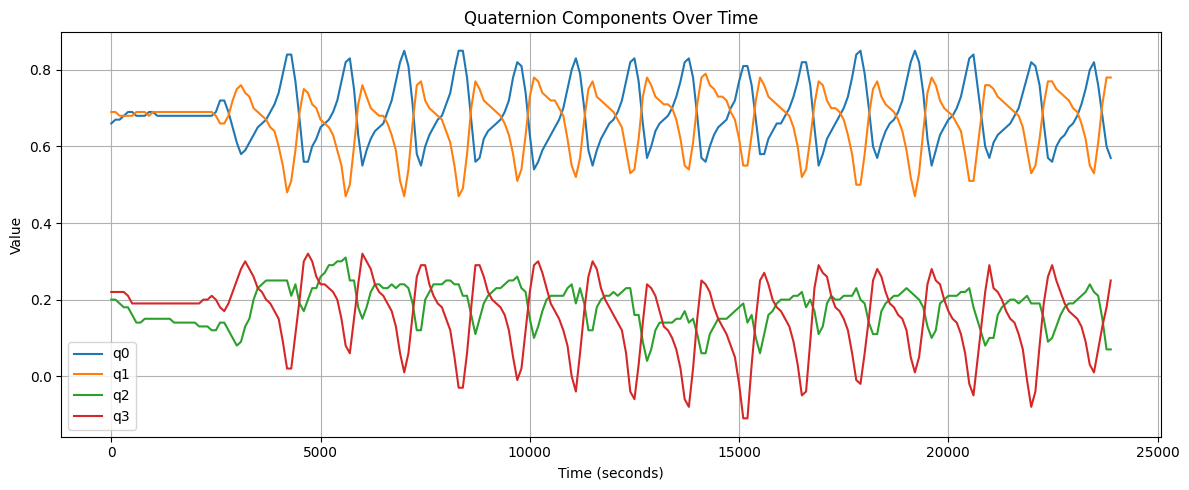

In [95]:
plt.figure(figsize=(12, 5))

plt.plot(df["time_sec"], df["q0"], label="q0")
plt.plot(df["time_sec"], df["q1"], label="q1")
plt.plot(df["time_sec"], df["q2"], label="q2")
plt.plot(df["time_sec"], df["q3"], label="q3")

plt.title("Quaternion Components Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


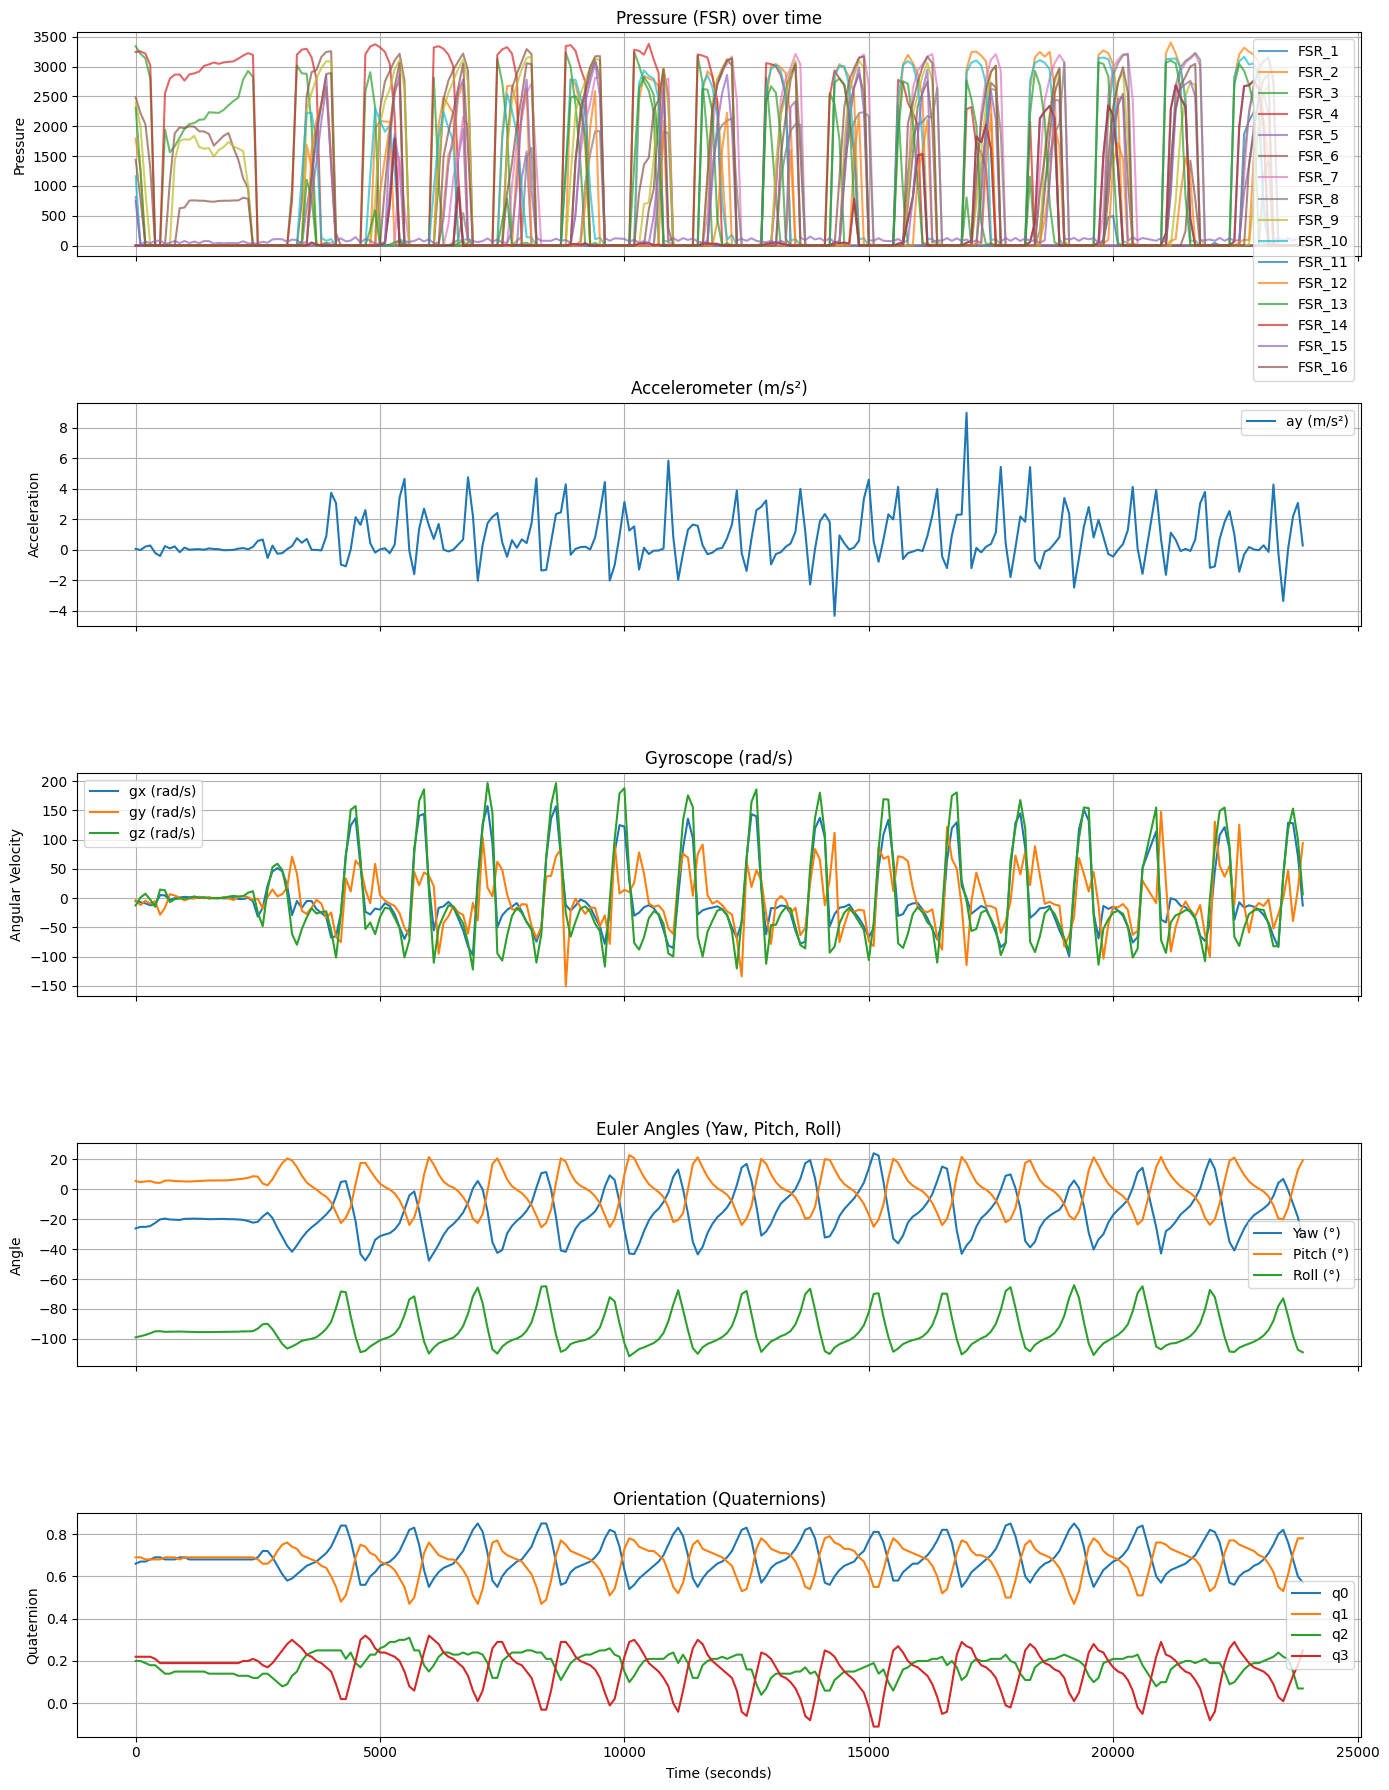

In [96]:
fig, axs = plt.subplots(5, 1, figsize=(14, 18), sharex=True)

# 1. Region Pressure
for i in range(1, 17):
    axs[0].plot(df["time_sec"], df[f"FSR_{i}"], label=f"FSR_{i}", alpha=0.7)
axs[0].set_ylabel("Pressure")
axs[0].set_title("Pressure (FSR) over time")
axs[0].legend()
axs[0].grid(True)

# 2. Accelerometer (m/s²)
#axs[1].plot(df["time_sec"], df["ax"], label="ax (m/s²)")
axs[1].plot(df["time_sec"], df["ay"], label="ay (m/s²)")
#axs[1].plot(df["time_sec"], df["az"], label="az (m/s²)")
axs[1].set_ylabel("Acceleration")
axs[1].set_title("Accelerometer (m/s²)")
axs[1].legend()
axs[1].grid(True)

# 3. Gyroscope (rad/s)
axs[2].plot(df["time_sec"], df["gx"], label="gx (rad/s)")
axs[2].plot(df["time_sec"], df["gy"], label="gy (rad/s)")
axs[2].plot(df["time_sec"], df["gz"], label="gz (rad/s)")
axs[2].set_ylabel("Angular Velocity")
axs[2].set_title("Gyroscope (rad/s)")
axs[2].legend()
axs[2].grid(True)

# 4. Euler Angles (degrees)
axs[3].plot(df["time_sec"], df["yaw"], label="Yaw (°)")
axs[3].plot(df["time_sec"], df["pitch"], label="Pitch (°)")
axs[3].plot(df["time_sec"], df["roll"], label="Roll (°)")
axs[3].set_ylabel("Angle")
axs[3].set_title("Euler Angles (Yaw, Pitch, Roll)")
axs[3].legend()
axs[3].grid(True)

# 5. Quaternions
axs[4].plot(df["time_sec"], df["q0"], label="q0")
axs[4].plot(df["time_sec"], df["q1"], label="q1")
axs[4].plot(df["time_sec"], df["q2"], label="q2")
axs[4].plot(df["time_sec"], df["q3"], label="q3")
axs[4].set_xlabel("Time (seconds)")
axs[4].set_ylabel("Quaternion")
axs[4].set_title("Orientation (Quaternions)")
axs[4].legend()
axs[4].grid(True)

plt.tight_layout()
plt.show()


### Region Wise Processing

### Foot Region to Sensor Mapping

| Region Name  | Sensors Included                                                  | Function in Gait Cycle       |
| ------------ | ----------------------------------------------------------------- | ---------------------------- |
| **Forefoot** | FSR\_5, FSR\_6, FSR\_7, FSR\_8, FSR\_9, FSR\_12, FSR\_15, FSR\_16 | Toe-off, Push-off            |
| **Midfoot**  | FSR\_1, FSR\_2, FSR\_10, FSR\_11, FSR\_13, FSR\_14                | Load-bearing, Mid-stance     |
| **Rearfoot** | FSR\_3, FSR\_4                                                    | Heel strike, Initial contact |


In [97]:
REGION_MAP = {
    "forefoot": [5, 6, 7, 8, 9, 12, 15, 16],
    "midfoot": [1, 2, 10, 11, 13,14],
    "rearfoot": [3, 4]
}


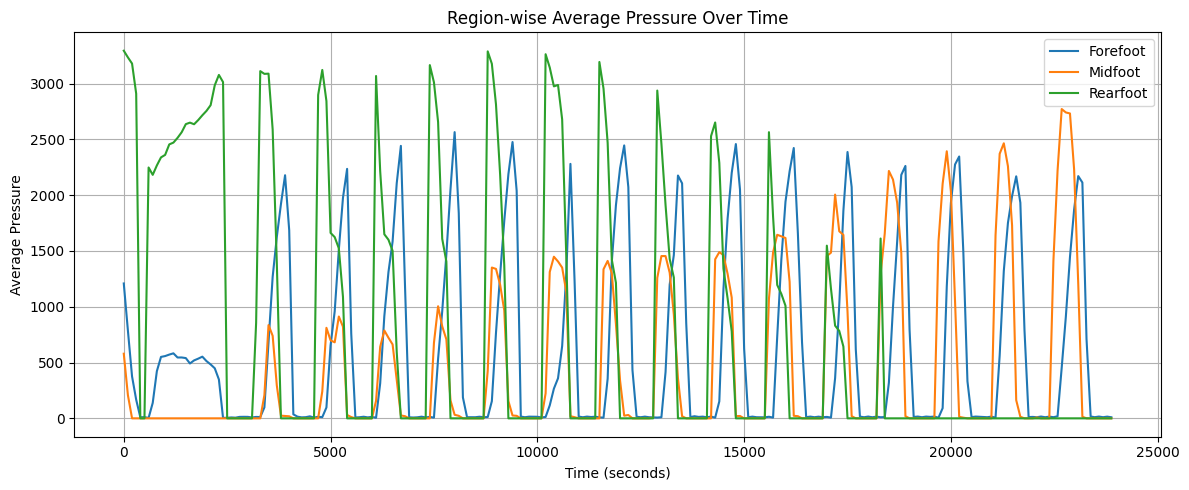

In [98]:
# Recompute region averages (in case changes were made)
for region, sensors in REGION_MAP.items():
    df[region] = df[[f"FSR_{i}" for i in sensors]].mean(axis=1)

# Plot region pressure over time
plt.figure(figsize=(12, 5))
for region in REGION_MAP:
    plt.plot(df["time_sec"], df[region], label=region.capitalize())

plt.title("Region-wise Average Pressure Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Average Pressure")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [99]:
fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# --- Subplot 1: Region-wise Pressure ---
for region in REGION_MAP:
    axs[0].plot(df["time_sec"], df[region], label=region.capitalize())
axs[0].set_ylabel("Average Pressure")
axs[0].set_title("Region-wise Average Pressure Over Time")
axs[0].legend()
axs[0].grid(True)

# --- Subplot 2: Accelerometer (m/s²) ---
#axs[1].plot(df["time_sec"], df["ax"], label="ax (m/s²)")
axs[1].plot(df["time_sec"], df["ay"], label="ay (m/s²)")
#axs[1].plot(df["time_sec"], df["az"], label="az (m/s²)")
axs[1].set_ylabel("Acceleration (m/s²)")
axs[1].set_xlabel("Time (seconds)")
axs[1].set_title("Accelerometer Readings Over Time (BNO055)")
axs[1].legend()
axs[1].grid(True)

axs[2].plot(df["time_sec"], df["ax"], label="ax (m/s²)")
#axs[1].plot(df["time_sec"], df["ay"], label="ay (m/s²)")
#axs[1].plot(df["time_sec"], df["az"], label="az (m/s²)")
axs[2].set_ylabel("Acceleration (m/s²)")
axs[2].set_xlabel("Time (seconds)")
axs[2].set_title("Accelerometer Readings Over Time (BNO055)")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


### Zoomed Time Window (5000 - 10000)

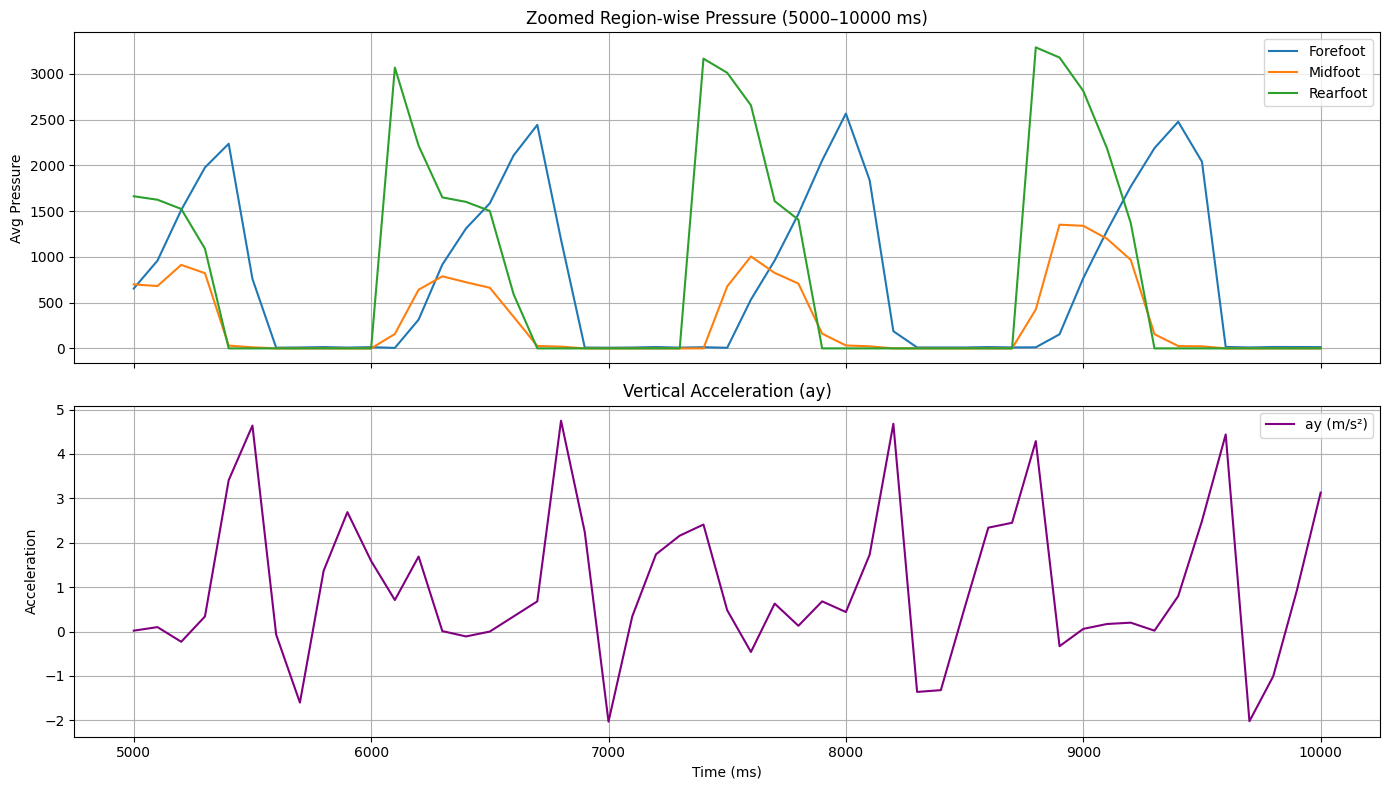

In [100]:
# Filter data for the zoomed window
df_zoom = df[(df["time_sec"] >= 5000) & (df["time_sec"] <= 10000)].copy()

# Plot region-wise pressure and ay in two subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Subplot 1: Region-wise Pressure
for region in REGION_MAP:
    axs[0].plot(df_zoom["time_sec"], df_zoom[region], label=region.capitalize())
axs[0].set_ylabel("Avg Pressure")
axs[0].set_title("Zoomed Region-wise Pressure (5000–10000 ms)")
axs[0].legend()
axs[0].grid(True)

# Subplot 2: Vertical Acceleration (ay)
axs[1].plot(df_zoom["time_sec"], df_zoom["ay"], label="ay (m/s²)", color='purple')
axs[1].set_ylabel("Acceleration")
axs[1].set_xlabel("Time (ms)")
axs[1].set_title("Vertical Acceleration (ay)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


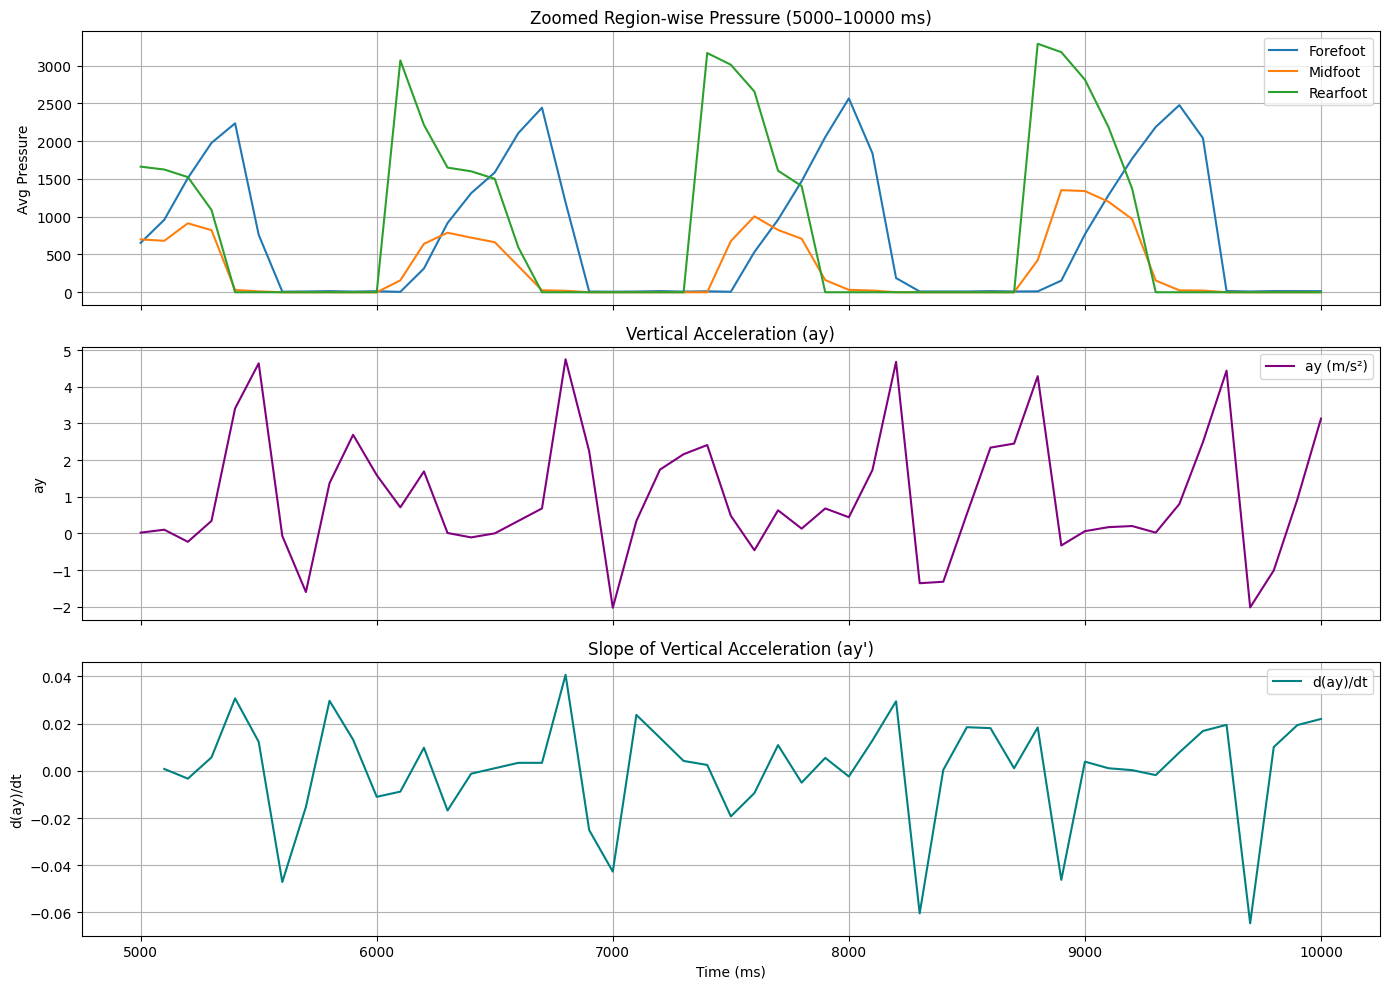

In [101]:
# Compute first derivative of ay (approximate)
df_zoom["d_ay"] = df_zoom["ay"].diff() / df_zoom["time_sec"].diff()

# Plot with an added subplot
fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# 1. Region Pressure
for region in REGION_MAP:
    axs[0].plot(df_zoom["time_sec"], df_zoom[region], label=region.capitalize())
axs[0].set_ylabel("Avg Pressure")
axs[0].set_title("Zoomed Region-wise Pressure (5000–10000 ms)")
axs[0].legend()
axs[0].grid(True)

# 2. Vertical Acceleration
axs[1].plot(df_zoom["time_sec"], df_zoom["ay"], label="ay (m/s²)", color='purple')
axs[1].set_ylabel("ay")
axs[1].set_title("Vertical Acceleration (ay)")
axs[1].legend()
axs[1].grid(True)

# 3. First Derivative of ay
axs[2].plot(df_zoom["time_sec"], df_zoom["d_ay"], label="d(ay)/dt", color='teal')
axs[2].set_ylabel("d(ay)/dt")
axs[2].set_xlabel("Time (ms)")
axs[2].set_title("Slope of Vertical Acceleration (ay')")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


### FSR , Accelaration , Slope of Acceleration and slope of FSR

In [102]:
# Compute derivatives for rearfoot and forefoot
df_zoom["d_rearfoot"] = df_zoom["rearfoot"].diff() / df_zoom["time_sec"].diff()
df_zoom["d_forefoot"] = df_zoom["forefoot"].diff() / df_zoom["time_sec"].diff()

# Plot everything: pressure + ay + ay' + pressure derivatives
fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# 1. Region Pressure
for region in REGION_MAP:
    axs[0].plot(df_zoom["time_sec"], df_zoom[region], label=region.capitalize())
axs[0].set_ylabel("Avg Pressure")
axs[0].set_title("Region-wise Pressure (Zoomed)")
axs[0].legend()
axs[0].grid(True)

# 2. Vertical Acceleration
axs[1].plot(df_zoom["time_sec"], df_zoom["ay"], label="ay (m/s²)", color='purple')
axs[1].set_ylabel("ay")
axs[1].set_title("Vertical Acceleration")
axs[1].legend()
axs[1].grid(True)

# 3. Slope of ay
axs[2].plot(df_zoom["time_sec"], df_zoom["d_ay"], label="d(ay)/dt", color='teal')
axs[2].set_ylabel("d(ay)/dt")
axs[2].set_title("Vertical Acceleration Derivative")
axs[2].legend()
axs[2].grid(True)

# 4. Derivative of Force
axs[3].plot(df_zoom["time_sec"], df_zoom["d_rearfoot"], label="d(Rearfoot)", color="green")
axs[3].plot(df_zoom["time_sec"], df_zoom["d_forefoot"], label="d(Forefoot)", color="blue")
axs[3].set_ylabel("d(Pressure)/dt")
axs[3].set_xlabel("Time (ms)")
axs[3].set_title("Slopes of Rearfoot and Forefoot Pressure")
axs[3].legend()
axs[3].grid(True)

plt.tight_layout()
plt.show()


### Initial Contact(IC/Heel Strike) Detection using deravite of the Rearfoot Pressure

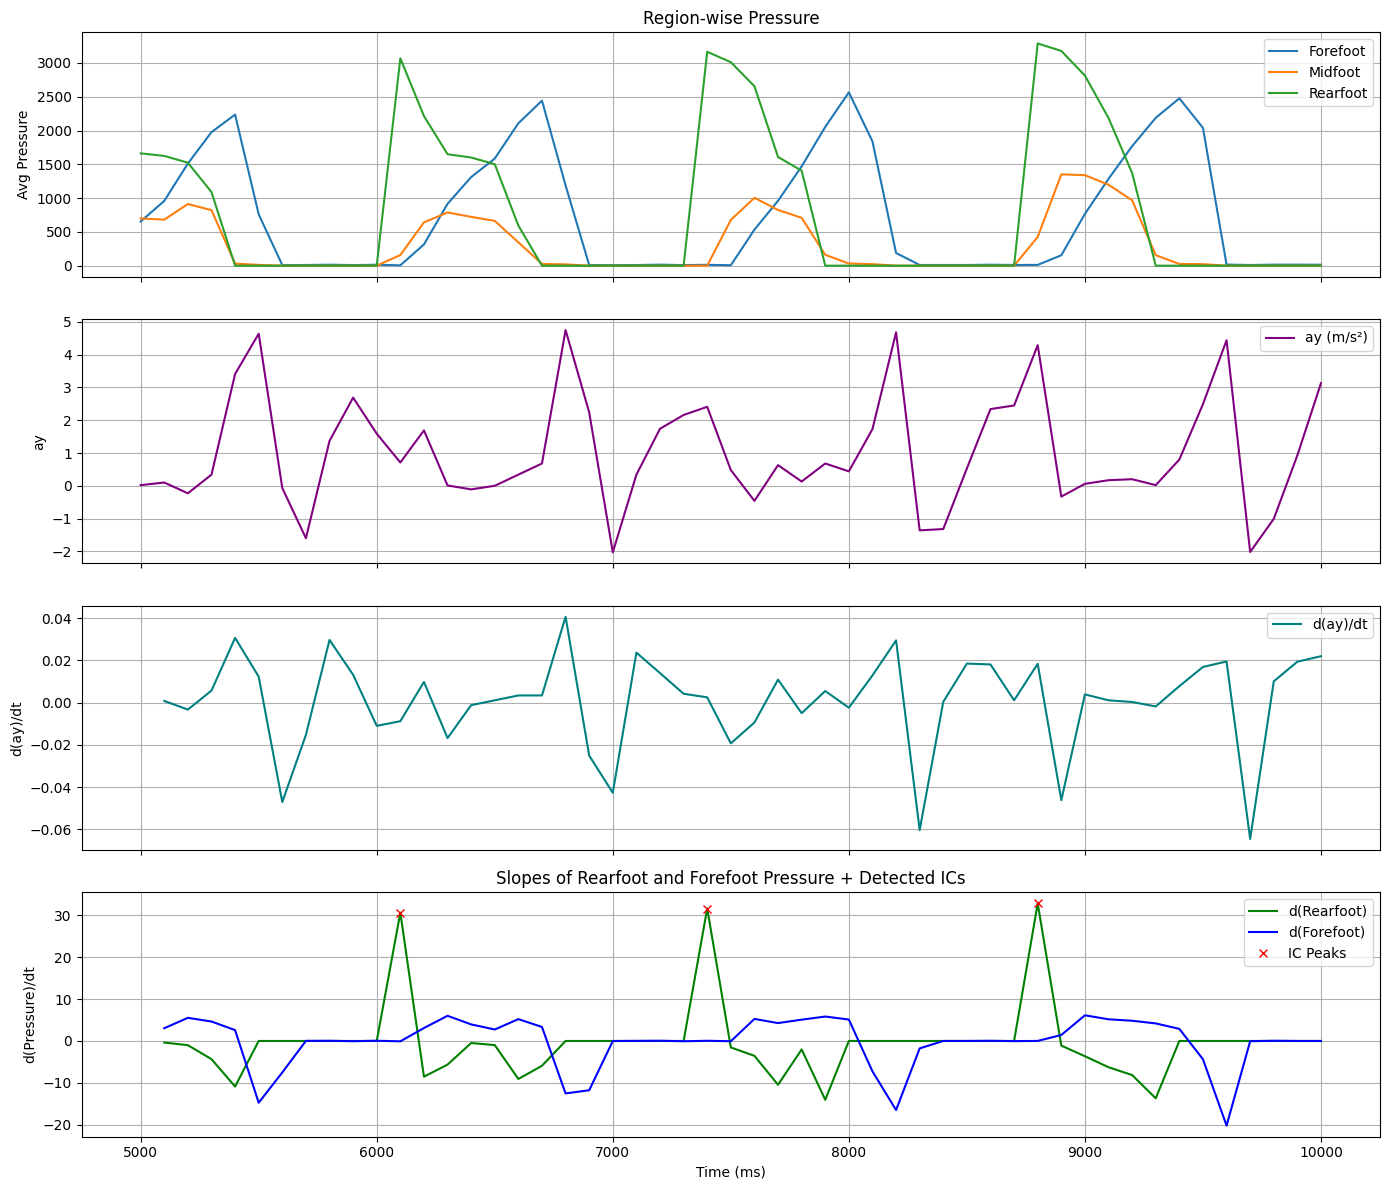

In [103]:
from scipy.signal import find_peaks

# Detect peaks in d_rearfoot (Initial Contact)
peaks_ic, _ = find_peaks(df_zoom["d_rearfoot"], height=10, distance=10)

# Plot to visualize detected ICs
fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# 1. Region Pressure
for region in REGION_MAP:
    axs[0].plot(df_zoom["time_sec"], df_zoom[region], label=region.capitalize())
axs[0].set_ylabel("Avg Pressure")
axs[0].set_title("Region-wise Pressure")
axs[0].legend()
axs[0].grid(True)

# 2. Vertical Acceleration
axs[1].plot(df_zoom["time_sec"], df_zoom["ay"], label="ay (m/s²)", color='purple')
axs[1].set_ylabel("ay")
axs[1].legend()
axs[1].grid(True)

# 3. ay'
axs[2].plot(df_zoom["time_sec"], df_zoom["d_ay"], label="d(ay)/dt", color='teal')
axs[2].set_ylabel("d(ay)/dt")
axs[2].legend()
axs[2].grid(True)

# 4. Derivatives with IC Markers
axs[3].plot(df_zoom["time_sec"], df_zoom["d_rearfoot"], label="d(Rearfoot)", color="green")
axs[3].plot(df_zoom["time_sec"], df_zoom["d_forefoot"], label="d(Forefoot)", color="blue")

# Mark IC peaks
axs[3].plot(df_zoom["time_sec"].iloc[peaks_ic], df_zoom["d_rearfoot"].iloc[peaks_ic], "rx", label="IC Peaks")

axs[3].set_ylabel("d(Pressure)/dt")
axs[3].set_xlabel("Time (ms)")
axs[3].set_title("Slopes of Rearfoot and Forefoot Pressure + Detected ICs")
axs[3].legend()
axs[3].grid(True)

plt.tight_layout()
plt.show()


In [104]:
from scipy.signal import find_peaks

# Detect IC peaks in d_rearfoot
peaks_ic, _ = find_peaks(df_zoom["d_rearfoot"], height=10, distance=5)
ic_times = df_zoom["time_sec"].iloc[peaks_ic]

# Plot
fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# 1. Region Pressure
for region in REGION_MAP:
    axs[0].plot(df_zoom["time_sec"], df_zoom[region], label=region.capitalize())
for t in ic_times:
    axs[0].axvline(x=t, color='red', linestyle='--', alpha=0.6)
axs[0].set_ylabel("Avg Pressure")
axs[0].set_title("Region-wise Pressure")
axs[0].legend()
axs[0].grid(True)

# 2. d_rearfoot + d_forefoot with IC peaks
axs[1].plot(df_zoom["time_sec"], df_zoom["d_rearfoot"], label="d(Rearfoot)", color="green")
axs[1].plot(df_zoom["time_sec"], df_zoom["d_forefoot"], label="d(Forefoot)", color="blue")
axs[1].plot(ic_times, df_zoom["d_rearfoot"].iloc[peaks_ic], "rx", label="IC Peaks")
for t in ic_times:
    axs[1].axvline(x=t, color='red', linestyle='--', alpha=0.6)
axs[1].set_ylabel("d(Pressure)/dt")
axs[1].set_xlabel("Time (ms)")
axs[1].set_title("Slopes + IC Markers")
axs[1].legend()
axs[1].grid(True)

# 3. ay
axs[2].plot(df_zoom["time_sec"], df_zoom["ay"], label="ay (m/s²)", color='purple')
for t in ic_times:
    axs[2].axvline(x=t, color='red', linestyle='--', alpha=0.6)
axs[2].set_ylabel("ay")
axs[2].legend()
axs[2].grid(True)

# 4. d_ay
axs[3].plot(df_zoom["time_sec"], df_zoom["d_ay"], label="d(ay)/dt", color='teal')
for t in ic_times:
    axs[3].axvline(x=t, color='red', linestyle='--', alpha=0.6)
axs[3].set_ylabel("d(ay)/dt")
axs[3].legend()
axs[3].grid(True)



plt.tight_layout()
plt.show()


Final conclusion : To detect IC use the deravtive of the RearFoot region pressure variation and find its Peaks 

In [108]:
from scipy.signal import butter, filtfilt

# Design low-pass Butterworth filter
def lowpass_filter(data, cutoff=1.5, fs=10, order=2):
    nyq = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Apply filter to ay
df_zoom["ay_filtered"] = lowpass_filter(df_zoom["ay"], cutoff=1.5, fs=10, order=2)
df_zoom["d(forefoot)_filtered"] = lowpass_filter(df_zoom["ay"], cutoff=1.5, fs=10, order=2)


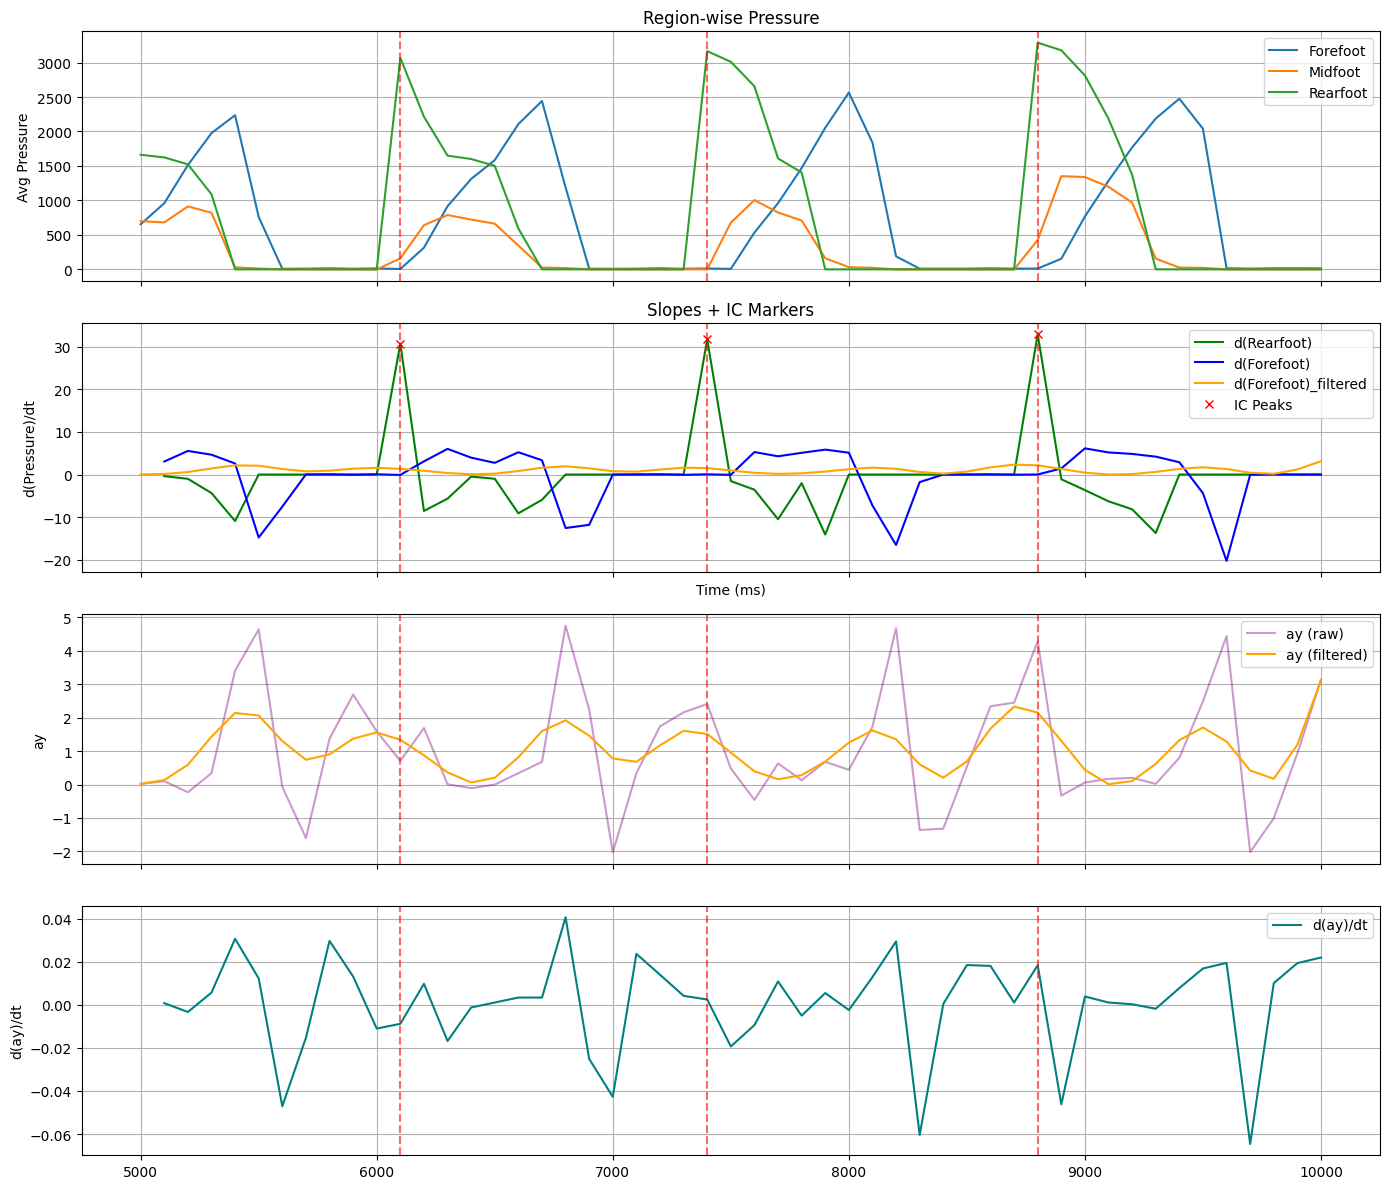

In [109]:
from scipy.signal import find_peaks

# Detect IC peaks in d_rearfoot
peaks_ic, _ = find_peaks(df_zoom["d_rearfoot"], height=10, distance=5)
ic_times = df_zoom["time_sec"].iloc[peaks_ic]

# Plot
fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# 1. Region Pressure
for region in REGION_MAP:
    axs[0].plot(df_zoom["time_sec"], df_zoom[region], label=region.capitalize())
for t in ic_times:
    axs[0].axvline(x=t, color='red', linestyle='--', alpha=0.6)
axs[0].set_ylabel("Avg Pressure")
axs[0].set_title("Region-wise Pressure")
axs[0].legend()
axs[0].grid(True)

# 2. d_rearfoot + d_forefoot with IC peaks
axs[1].plot(df_zoom["time_sec"], df_zoom["d_rearfoot"], label="d(Rearfoot)", color="green")
axs[1].plot(df_zoom["time_sec"], df_zoom["d_forefoot"], label="d(Forefoot)", color="blue")
axs[1].plot(df_zoom["time_sec"], df_zoom["d(forefoot)_filtered"], label="d(Forefoot)_filtered", color="orange")
axs[1].plot(ic_times, df_zoom["d_rearfoot"].iloc[peaks_ic], "rx", label="IC Peaks")
for t in ic_times:
    axs[1].axvline(x=t, color='red', linestyle='--', alpha=0.6)
axs[1].set_ylabel("d(Pressure)/dt")
axs[1].set_xlabel("Time (ms)")
axs[1].set_title("Slopes + IC Markers")
axs[1].legend()
axs[1].grid(True)

# 3. ay
axs[2].plot(df_zoom["time_sec"], df_zoom["ay"], label="ay (raw)", color='purple', alpha=0.4)
axs[2].plot(df_zoom["time_sec"], df_zoom["ay_filtered"], label="ay (filtered)", color='orange')
for t in ic_times:
    axs[2].axvline(x=t, color='red', linestyle='--', alpha=0.6)
axs[2].set_ylabel("ay")
axs[2].legend()
axs[2].grid(True)

# 4. d_ay
axs[3].plot(df_zoom["time_sec"], df_zoom["d_ay"], label="d(ay)/dt", color='teal')
for t in ic_times:
    axs[3].axvline(x=t, color='red', linestyle='--', alpha=0.6)
axs[3].set_ylabel("d(ay)/dt")
axs[3].legend()
axs[3].grid(True)



plt.tight_layout()
plt.show()


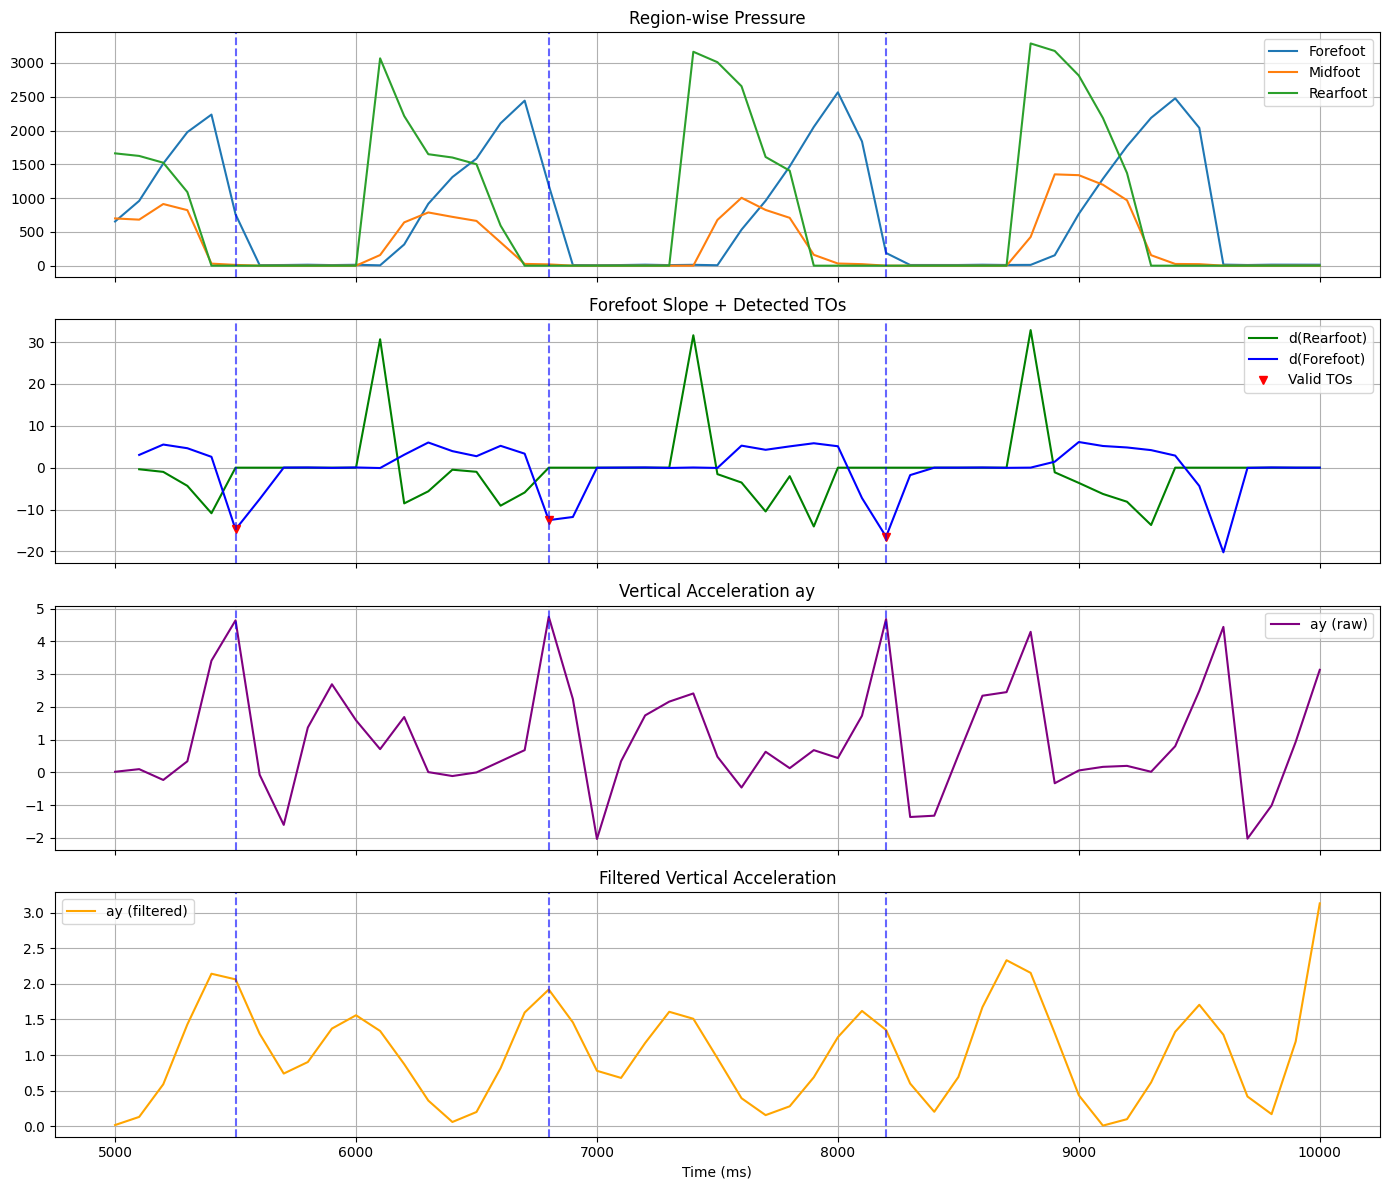

In [111]:
from scipy.signal import find_peaks

# Step 1: Detect features
neg_peaks_df, _ = find_peaks(-df_zoom["d_forefoot"], height=10, distance=10)
forefoot_peaks, _ = find_peaks(df_zoom["forefoot"], height=500)
ay_peaks, _ = find_peaks(df_zoom["ay"], height=3)

# Step 2: Filter valid TOs
valid_to_idxs = []

for peak_idx in neg_peaks_df:
    # Forefoot peak before
    prev_peaks = forefoot_peaks[forefoot_peaks < peak_idx]
    if len(prev_peaks) == 0:
        continue
    forefoot_peak_idx = prev_peaks[-1]

    # Zero crossing after
    after = df_zoom["forefoot"].iloc[peak_idx:].reset_index(drop=True)
    zero_cross = after[after < 100]
    if len(zero_cross) == 0:
        continue
    zero_cross_idx = peak_idx + zero_cross.index[0]

    # Check for ay peak in window
    if any(forefoot_peak_idx < ay < zero_cross_idx for ay in ay_peaks):
        valid_to_idxs.append(peak_idx)

# Extract times
to_times = df_zoom["time_sec"].iloc[valid_to_idxs]

# Step 3: Plot
fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# 1. Region Pressure
for region in REGION_MAP:
    axs[0].plot(df_zoom["time_sec"], df_zoom[region], label=region.capitalize())
for t in to_times:
    axs[0].axvline(x=t, color='blue', linestyle='--', alpha=0.6)
axs[0].set_title("Region-wise Pressure")
axs[0].legend()
axs[0].grid(True)

# 2. d_rearfoot + d_forefoot + TO ticks
axs[1].plot(df_zoom["time_sec"], df_zoom["d_rearfoot"], label="d(Rearfoot)", color="green")
axs[1].plot(df_zoom["time_sec"], df_zoom["d_forefoot"], label="d(Forefoot)", color="blue")
axs[1].plot(df_zoom["time_sec"].iloc[valid_to_idxs], df_zoom["d_forefoot"].iloc[valid_to_idxs], "rv", label="Valid TOs")
for t in to_times:
    axs[1].axvline(x=t, color='blue', linestyle='--', alpha=0.6)
axs[1].legend()
axs[1].grid(True)
axs[1].set_title("Forefoot Slope + Detected TOs")

# 3. ay
axs[2].plot(df_zoom["time_sec"], df_zoom["ay"], label="ay (raw)", color="purple")
for t in to_times:
    axs[2].axvline(x=t, color='blue', linestyle='--', alpha=0.6)
axs[2].legend()
axs[2].grid(True)
axs[2].set_title("Vertical Acceleration ay")

# 4. ay_filtered
if "ay_filtered" in df_zoom.columns:
    axs[3].plot(df_zoom["time_sec"], df_zoom["ay_filtered"], label="ay (filtered)", color="orange")
    for t in to_times:
        axs[3].axvline(x=t, color='blue', linestyle='--', alpha=0.6)
    axs[3].legend()
    axs[3].grid(True)
    axs[3].set_title("Filtered Vertical Acceleration")

axs[-1].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()


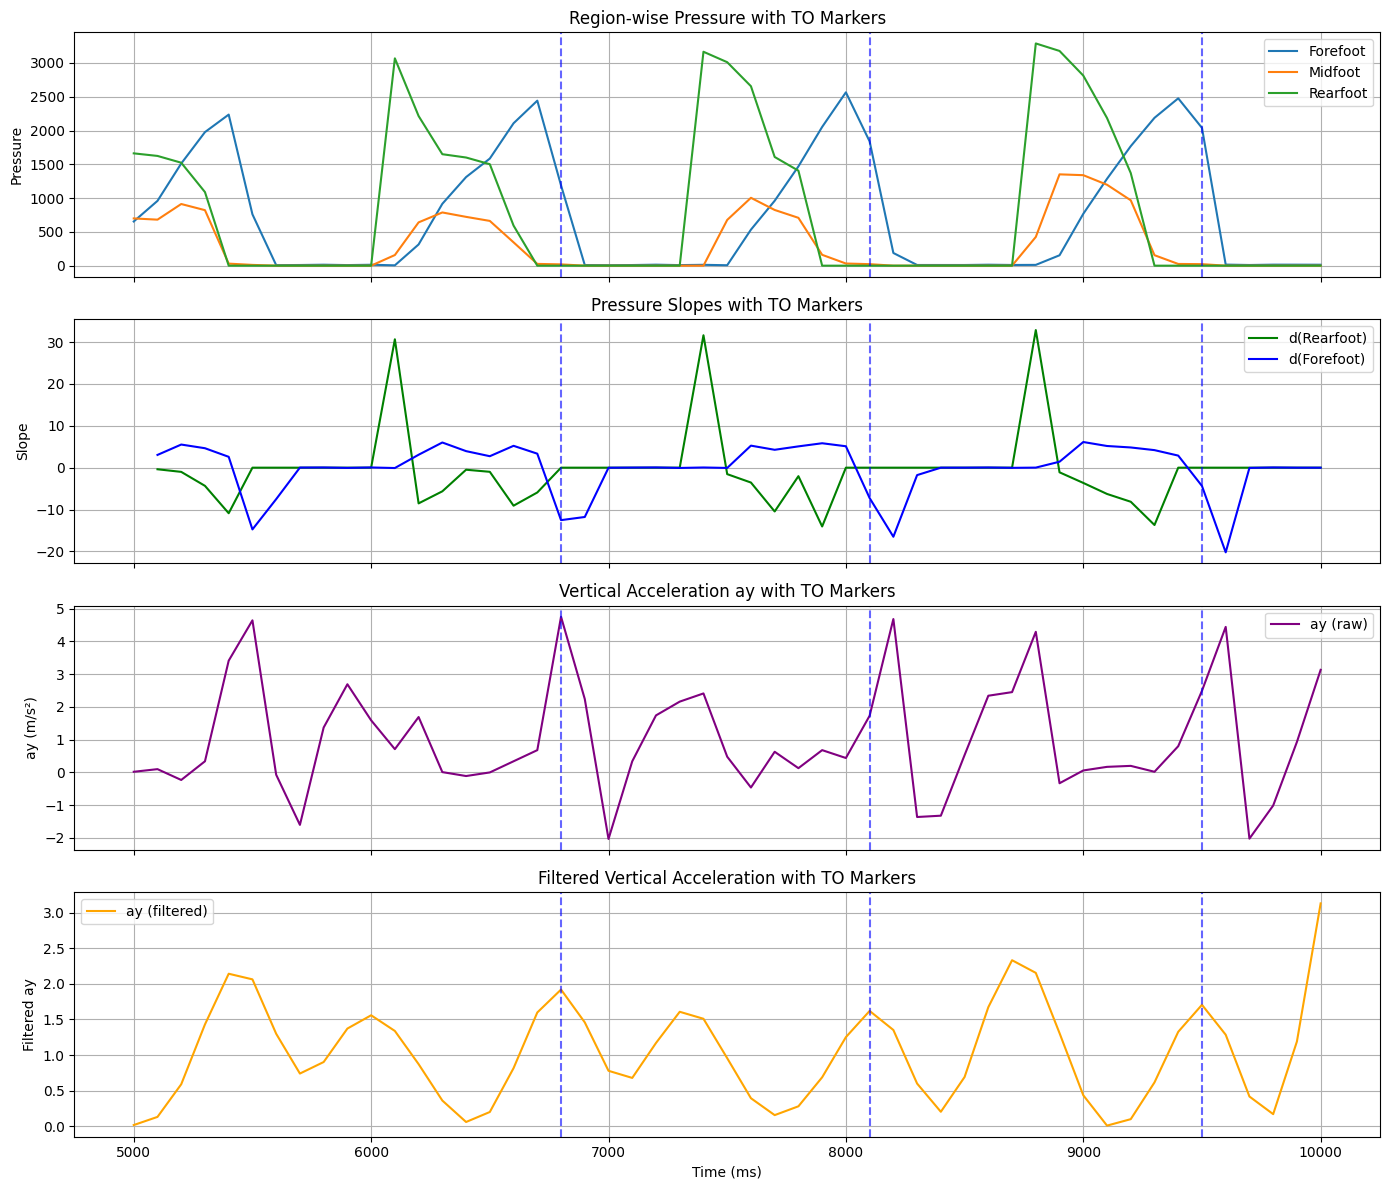

In [ ]:
from scipy.signal import find_peaks

# Step 1: Detect relevant peaks
forefoot_peaks, _ = find_peaks(df_zoom["forefoot"], height=500)
ay_peaks, _ = find_peaks(df_zoom["ay_filtered"], height=1)
neg_peaks_df, _ = find_peaks(-df_zoom["d_forefoot"], height=10)

# Step 2: Loop through each forefoot peak
to_times = []

for fp_idx in forefoot_peaks:
    # Find the zero crossing (forefoot near 0) after the peak
    after = df_zoom["forefoot"].iloc[fp_idx:].reset_index(drop=True)
    zero_cross = after[after < 100]
    if len(zero_cross) == 0:
        continue
    zero_cross_idx = fp_idx + zero_cross.index[0]

    # Check for valid condition: either slope or ay_filtered peak
    df_neg = [i for i in neg_peaks_df if fp_idx < i < zero_cross_idx]
    ayf_peaks = [i for i in ay_peaks if fp_idx < i < zero_cross_idx]

    if len(df_neg) > 0 or len(ayf_peaks) > 0:
        if len(ayf_peaks) > 0:
            chosen_idx = ayf_peaks[0]
            to_times.append(df_zoom["time_sec"].iloc[chosen_idx])

# Step 3: Plot with TO vertical markers
fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# 1. Region-wise Pressure
for region in REGION_MAP:
    axs[0].plot(df_zoom["time_sec"], df_zoom[region], label=region.capitalize())
for t in to_times:
    axs[0].axvline(x=t, color='blue', linestyle='--', alpha=0.6)
axs[0].set_ylabel("Pressure")
axs[0].set_title("Region-wise Pressure with TO Markers")
axs[0].legend()
axs[0].grid(True)

# 2. d_rearfoot + d_forefoot
axs[1].plot(df_zoom["time_sec"], df_zoom["d_rearfoot"], label="d(Rearfoot)", color="green")
axs[1].plot(df_zoom["time_sec"], df_zoom["d_forefoot"], label="d(Forefoot)", color="blue")
for t in to_times:
    axs[1].axvline(x=t, color='blue', linestyle='--', alpha=0.6)
axs[1].set_ylabel("Slope")
axs[1].set_title("Pressure Slopes with TO Markers")
axs[1].legend()
axs[1].grid(True)

# 3. ay (raw)
axs[2].plot(df_zoom["time_sec"], df_zoom["ay"], label="ay (raw)", color="purple")
for t in to_times:
    axs[2].axvline(x=t, color='blue', linestyle='--', alpha=0.6)
axs[2].set_ylabel("ay (m/s²)")
axs[2].set_title("Vertical Acceleration ay with TO Markers")
axs[2].legend()
axs[2].grid(True)

# 4. ay_filtered with TO markers
axs[3].plot(df_zoom["time_sec"], df_zoom["ay_filtered"], label="ay (filtered)", color="orange")
for t in to_times:
    axs[3].axvline(x=t, color='blue', linestyle='--', alpha=0.6)
axs[3].set_ylabel("Filtered ay")
axs[3].set_title("Filtered Vertical Acceleration with TO Markers")
axs[3].legend()
axs[3].grid(True)

axs[-1].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()


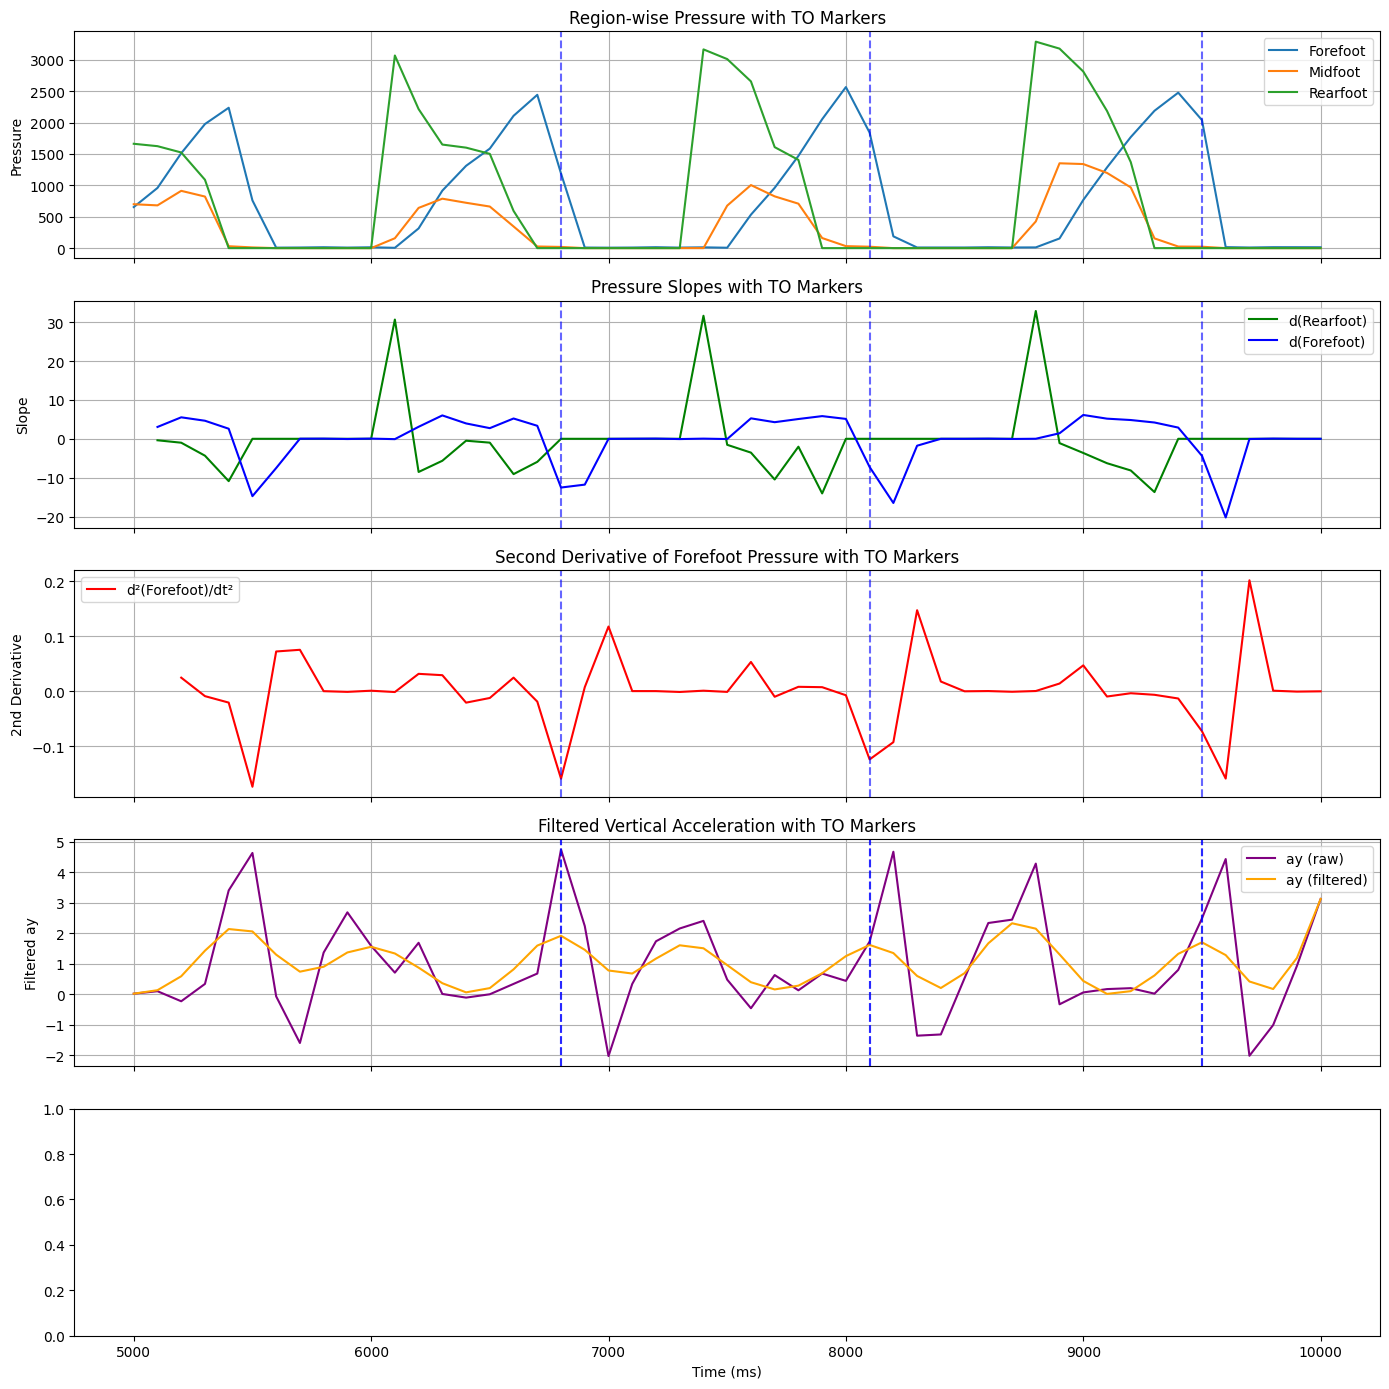

In [ ]:
# Compute second derivative
df_zoom["dd_forefoot"] = df_zoom["d_forefoot"].diff() / df_zoom["time_sec"].diff()

# Existing detection logic assumed to be run earlier
# to_times = [...]  # From previously validated Toe-Off detection
# Step 1: Detect relevant peaks
forefoot_peaks, _ = find_peaks(df_zoom["forefoot"], height=500)
ay_peaks, _ = find_peaks(df_zoom["ay_filtered"], height=1)
neg_peaks_df, _ = find_peaks(-df_zoom["d_forefoot"], height=10)

# Step 2: Loop through each forefoot peak
to_times = []

for fp_idx in forefoot_peaks:
    # Find the zero crossing (forefoot near 0) after the peak
    after = df_zoom["forefoot"].iloc[fp_idx:].reset_index(drop=True)
    zero_cross = after[after < 100]
    if len(zero_cross) == 0:
        continue
    zero_cross_idx = fp_idx + zero_cross.index[0]

    # Check for valid condition: either slope or ay_filtered peak
    df_neg = [i for i in neg_peaks_df if fp_idx < i < zero_cross_idx]
    ayf_peaks = [i for i in ay_peaks if fp_idx < i < zero_cross_idx]

    if len(df_neg) > 0 or len(ayf_peaks) > 0:
        if len(ayf_peaks) > 0:
            chosen_idx = ayf_peaks[0]
            to_times.append(df_zoom["time_sec"].iloc[chosen_idx])

# Plot with added subplot
fig, axs = plt.subplots(5, 1, figsize=(14, 14), sharex=True)

# 1. Region-wise Pressure
for region in REGION_MAP:
    axs[0].plot(df_zoom["time_sec"], df_zoom[region], label=region.capitalize())
for t in to_times:
    axs[0].axvline(x=t, color='blue', linestyle='--', alpha=0.6)
axs[0].set_ylabel("Pressure")
axs[0].set_title("Region-wise Pressure with TO Markers")
axs[0].legend()
axs[0].grid(True)

# 2. d_rearfoot + d_forefoot
axs[1].plot(df_zoom["time_sec"], df_zoom["d_rearfoot"], label="d(Rearfoot)", color="green")
axs[1].plot(df_zoom["time_sec"], df_zoom["d_forefoot"], label="d(Forefoot)", color="blue")
for t in to_times:
    axs[1].axvline(x=t, color='blue', linestyle='--', alpha=0.6)
axs[1].set_ylabel("Slope")
axs[1].set_title("Pressure Slopes with TO Markers")
axs[1].legend()
axs[1].grid(True)

# 3. ay (raw)
axs[3].plot(df_zoom["time_sec"], df_zoom["ay"], label="ay (raw)", color="purple")
for t in to_times:
    axs[3].axvline(x=t, color='blue', linestyle='--', alpha=0.6)
axs[3].set_ylabel("ay (m/s²)")
axs[3].set_title("Vertical Acceleration ay with TO Markers")
axs[3].legend()
axs[3].grid(True)

# 4. ay_filtered
axs[3].plot(df_zoom["time_sec"], df_zoom["ay_filtered"], label="ay (filtered)", color="orange")
for t in to_times:
    axs[3].axvline(x=t, color='blue', linestyle='--', alpha=0.6)
axs[3].set_ylabel("Filtered ay")
axs[3].set_title("Filtered Vertical Acceleration with TO Markers")
axs[3].legend()
axs[3].grid(True)

# 5. Second derivative of forefoot force
axs[2].plot(df_zoom["time_sec"], df_zoom["dd_forefoot"], label="d²(Forefoot)/dt²", color="red")
for t in to_times:
    axs[2].axvline(x=t, color='blue', linestyle='--', alpha=0.6)
axs[2].set_ylabel("2nd Derivative")
axs[2].set_title("Second Derivative of Forefoot Pressure with TO Markers")
axs[2].legend()
axs[2].grid(True)

axs[-1].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()


### final logic to detect Toe Off
Forefoot peak → zero crossing defines a candidate TO region.

Region is valid if:

A negative peak in dd_forefoot (< -0.05) OR

A positive peak in ay_filtered (height > 1)

If both A and B, prefer dd_forefoot peak.

If only one of A or B, use the corresponding peak.

If neither, fallback to midpoint only if dd_forefoot[mid] < 0.

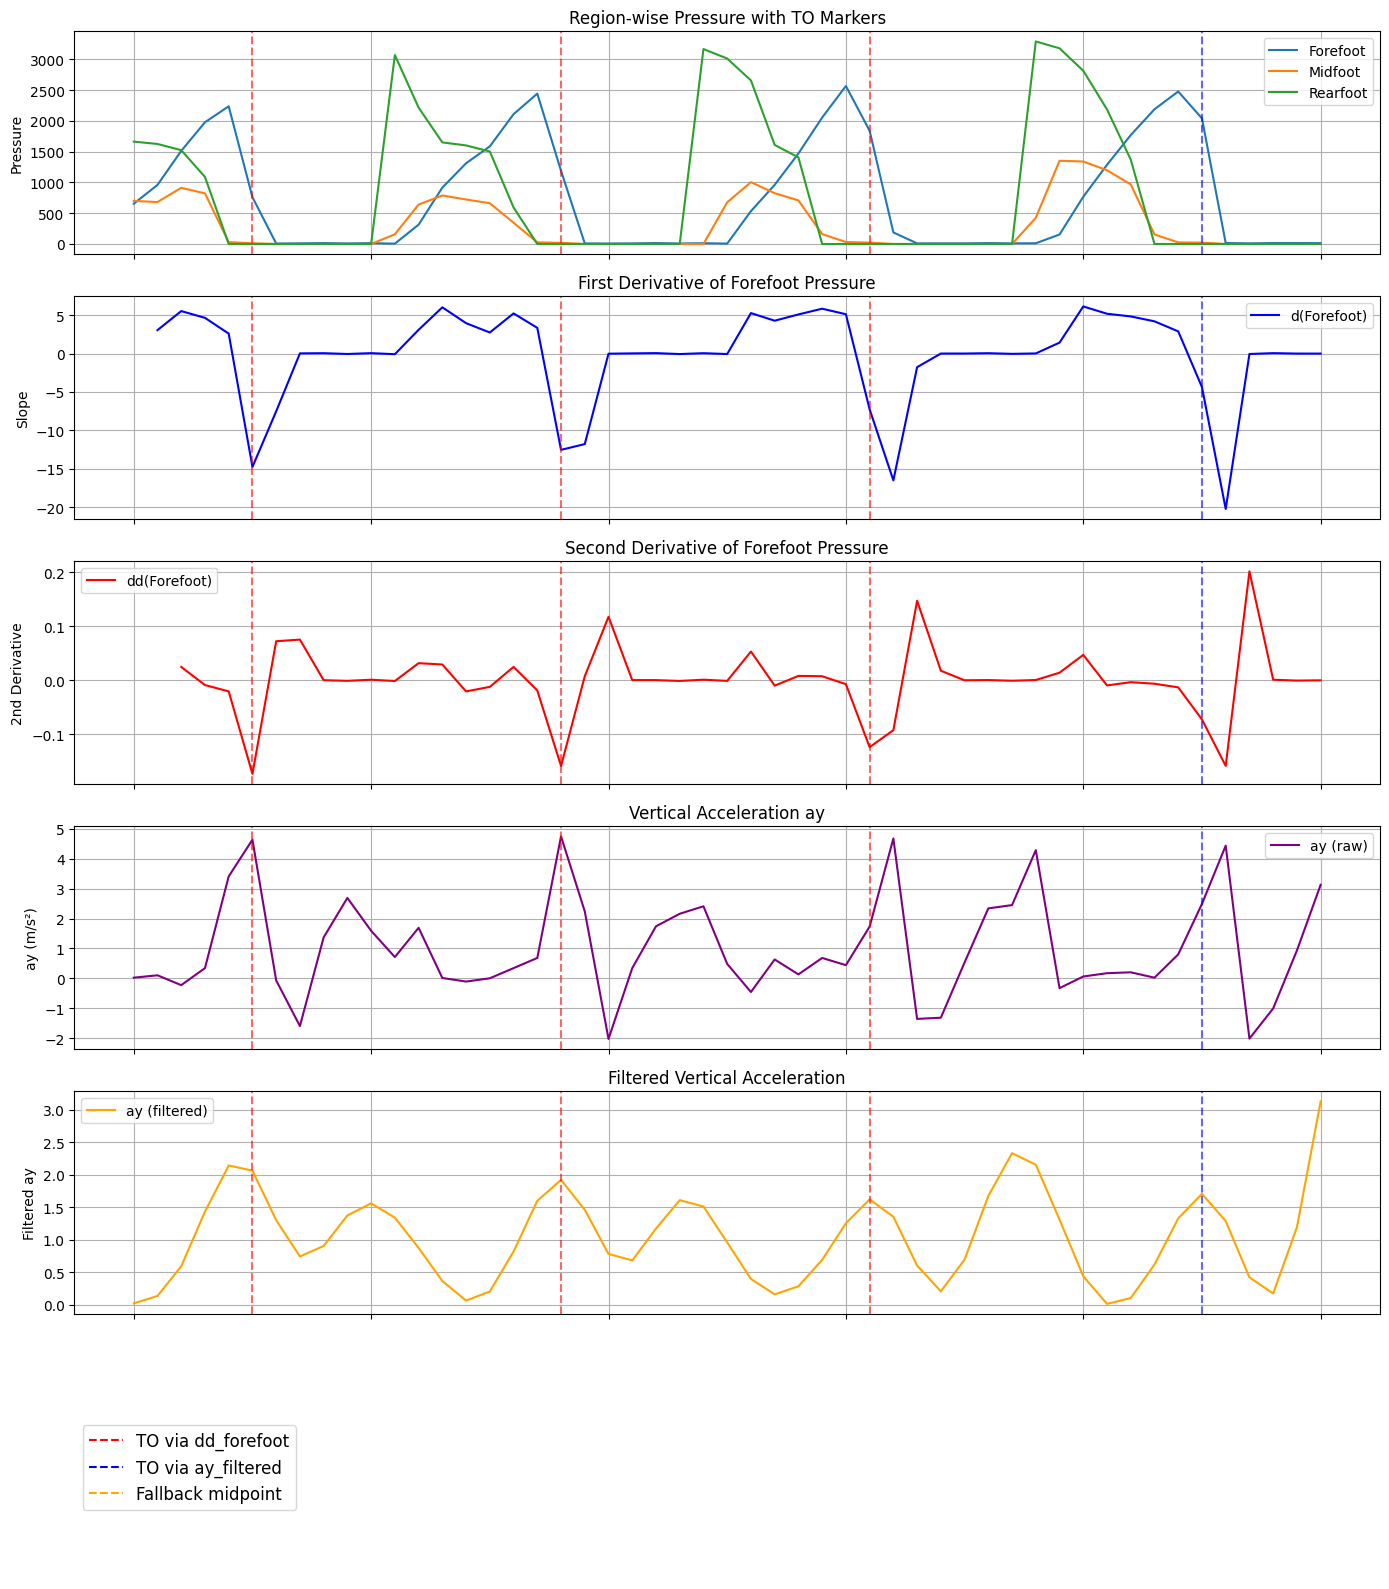

In [ ]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# --- Step 1: Detect Peaks ---
forefoot_peaks, _ = find_peaks(df_zoom["forefoot"], height=500)
ay_peaks, _ = find_peaks(df_zoom["ay_filtered"], height=1)
dd_neg_peaks, _ = find_peaks(-df_zoom["dd_forefoot"], height=0.05)

# --- Step 2: Toe-Off Logic ---
to_times = []
to_labels = []

for fp_idx in forefoot_peaks:
    # Find zero crossing after forefoot peak
    after = df_zoom["forefoot"].iloc[fp_idx:].reset_index(drop=True)
    zero_cross = after[after < 100]
    if len(zero_cross) == 0:
        continue
    zc_idx = fp_idx + zero_cross.index[0]
    mid_idx = (fp_idx + zc_idx) // 2

    # Find peaks in window
    dd_peaks = [i for i in dd_neg_peaks if fp_idx < i < zc_idx]
    ayf_peaks = [i for i in ay_peaks if fp_idx < i < zc_idx]

    # Priority logic
    if dd_peaks and ayf_peaks:
        to_times.append(df_zoom["time_sec"].iloc[dd_peaks[0]])
        to_labels.append("dd")
    elif dd_peaks:
        to_times.append(df_zoom["time_sec"].iloc[dd_peaks[0]])
        to_labels.append("dd")
    elif ayf_peaks:
        to_times.append(df_zoom["time_sec"].iloc[ayf_peaks[0]])
        to_labels.append("ay")
    elif df_zoom["dd_forefoot"].iloc[mid_idx] < 0:
        to_times.append(df_zoom["time_sec"].iloc[mid_idx])
        to_labels.append("mid")
    # else: discard

# --- Step 3: Plot ---
fig, axs = plt.subplots(6, 1, figsize=(14, 16), sharex=True)

colors = {"dd": "red", "ay": "blue", "mid": "orange"}

# 1. Region-wise Pressure
for region in REGION_MAP:
    axs[0].plot(df_zoom["time_sec"], df_zoom[region], label=region.capitalize())
for t, lbl in zip(to_times, to_labels):
    axs[0].axvline(x=t, color=colors[lbl], linestyle='--', alpha=0.6)
axs[0].set_ylabel("Pressure")
axs[0].set_title("Region-wise Pressure with TO Markers")
axs[0].legend()
axs[0].grid(True)

# 2. d(Forefoot)
axs[1].plot(df_zoom["time_sec"], df_zoom["d_forefoot"], label="d(Forefoot)", color="blue")
for t, lbl in zip(to_times, to_labels):
    axs[1].axvline(x=t, color=colors[lbl], linestyle='--', alpha=0.6)
axs[1].set_ylabel("Slope")
axs[1].set_title("First Derivative of Forefoot Pressure")
axs[1].legend()
axs[1].grid(True)

# 3. dd(Forefoot)
axs[2].plot(df_zoom["time_sec"], df_zoom["dd_forefoot"], label="dd(Forefoot)", color="red")
for t, lbl in zip(to_times, to_labels):
    axs[2].axvline(x=t, color=colors[lbl], linestyle='--', alpha=0.6)
axs[2].set_ylabel("2nd Derivative")
axs[2].set_title("Second Derivative of Forefoot Pressure")
axs[2].legend()
axs[2].grid(True)

# 4. ay (raw)
axs[3].plot(df_zoom["time_sec"], df_zoom["ay"], label="ay (raw)", color="purple")
for t, lbl in zip(to_times, to_labels):
    axs[3].axvline(x=t, color=colors[lbl], linestyle='--', alpha=0.6)
axs[3].set_ylabel("ay (m/s²)")
axs[3].set_title("Vertical Acceleration ay")
axs[3].legend()
axs[3].grid(True)

# 5. ay_filtered
axs[4].plot(df_zoom["time_sec"], df_zoom["ay_filtered"], label="ay (filtered)", color="orange")
for t, lbl in zip(to_times, to_labels):
    axs[4].axvline(x=t, color=colors[lbl], linestyle='--', alpha=0.6)
axs[4].set_ylabel("Filtered ay")
axs[4].set_title("Filtered Vertical Acceleration")
axs[4].legend()
axs[4].grid(True)

# 6. Legend-only subplot
axs[5].axis('off')
axs[5].legend(
    handles=[
        plt.Line2D([0], [0], color='red', linestyle='--', label='TO via dd_forefoot'),
        plt.Line2D([0], [0], color='blue', linestyle='--', label='TO via ay_filtered'),
        plt.Line2D([0], [0], color='orange', linestyle='--', label='Fallback midpoint'),
    ],
    loc='center left',
    fontsize=12
)

axs[-1].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()


## Functions : Detecting IC and TO

In [190]:
from scipy.signal import find_peaks

def detect_ic_to(df,time_col="time_sec"):
    
    REGION_MAP = {
    "forefoot": [5, 6, 7, 8, 9, 12, 15, 16],
    "midfoot": [1, 2, 10, 11, 13,14],
    "rearfoot": [3, 4]
    }
    
    df = df.copy()

    # --- Step 0: Compute region-wise average pressures ---
    for region, indices in REGION_MAP.items():
        sensor_cols = [f"FSR_{i}" for i in indices]
        df[region] = df[sensor_cols].mean(axis=1)

    # --- Step 1: Preprocessing ---
    df["d_rearfoot"] = df["rearfoot"].diff() / df[time_col].diff()
    df["d_forefoot"] = df["forefoot"].diff() / df[time_col].diff()
    df["dd_forefoot"] = df["d_forefoot"].diff() / df[time_col].diff()

    # --- Step 2: Detect ICs ---
    ic_peaks, _ = find_peaks(df["d_rearfoot"], height=10, distance=5)
    ic_times = df[time_col].iloc[ic_peaks].to_list()

    # --- Step 3: Detect TOs using raw ay and dd_forefoot ---
    forefoot_peaks, _ = find_peaks(df["forefoot"], height=500)
    ay_peaks, _ = find_peaks(df["ay"], height=2)
    dd_neg_peaks, _ = find_peaks(-df["dd_forefoot"], height=0.05)

    to_times = []
    to_labels = []

    for fp_idx in forefoot_peaks:
        after = df["forefoot"].iloc[fp_idx:].reset_index(drop=True)
        zero_cross = after[after < 100]
        if len(zero_cross) == 0:
            continue
        zc_idx = fp_idx + zero_cross.index[0]
        mid_idx = (fp_idx + zc_idx) // 2

        dd_peaks = [i for i in dd_neg_peaks if fp_idx < i < zc_idx]
        ay_peaks_in_range = [i for i in ay_peaks if fp_idx < i < zc_idx]

        # Priority logic
        if dd_peaks and ay_peaks_in_range:
            to_times.append(df[time_col].iloc[dd_peaks[0]])
            to_labels.append("dd")
        elif dd_peaks:
            to_times.append(df[time_col].iloc[dd_peaks[0]])
            to_labels.append("dd")
        elif ay_peaks_in_range:
            to_times.append(df[time_col].iloc[ay_peaks_in_range[0]])
            to_labels.append("ay")
        elif df["dd_forefoot"].iloc[mid_idx] < 0:
            to_times.append(df[time_col].iloc[mid_idx])
            to_labels.append("mid")

    return {
        "ic_times": ic_times,
        "to_times": to_times,
        "to_labels": to_labels
    }


In [195]:
import matplotlib.pyplot as plt

def plot_ic_to(df, ic_times, to_times, to_labels,time_col="time_sec"):
    
    REGION_MAP = {
    "forefoot": [5, 6, 7, 8, 9, 12, 15, 16],
    "midfoot": [1, 2, 10, 11, 13,14],
    "rearfoot": [3, 4]
    }

    colors = {"dd": "red", "ay": "blue", "mid": "orange"}
    
    fig, axs = plt.subplots(5, 1, figsize=(14, 18), sharex=True)

    
    # Compute region pressures if missing
    for region, indices in REGION_MAP.items():
        if region not in df.columns:
            sensor_cols = [f"FSR_{i}" for i in indices]
            df[region] = df[sensor_cols].mean(axis=1)

    # Compute derivatives if missing
    if "d_rearfoot" not in df.columns:
        df["d_rearfoot"] = df["rearfoot"].diff() / df[time_col].diff()
    if "d_forefoot" not in df.columns:
        df["d_forefoot"] = df["forefoot"].diff() / df[time_col].diff()
    if "dd_forefoot" not in df.columns:
        df["dd_forefoot"] = df["d_forefoot"].diff() / df[time_col].diff()
    if "ay_filtered" not in df.columns:
        from scipy.signal import butter, filtfilt
        def butter_lowpass_filter(data, cutoff=5, fs=100, order=4):
            nyq = 0.5 * fs
            normal_cutoff = cutoff / nyq
            b, a = butter(order, normal_cutoff, btype='low', analog=False)
            return filtfilt(b, a, data)
        df["ay_filtered"] = butter_lowpass_filter(df["ay"])

    # 1. Region Pressure
    for region in REGION_MAP:
        axs[0].plot(df[time_col], df[region], label=region.capitalize())
    for t in ic_times:
        axs[0].axvline(x=t, color='green', linestyle='--', alpha=0.5)
    for t, lbl in zip(to_times, to_labels):
        axs[0].axvline(x=t, color=colors[lbl], linestyle='--', alpha=0.6)
    axs[0].set_title("Region-wise Pressure with IC (red) and TO Markers")
    axs[0].legend()
    axs[0].grid(True)

    # 2. d_rearfoot + d_forefoot
    axs[1].plot(df[time_col], df["d_rearfoot"], label="d(Rearfoot)", color="green")
    axs[1].plot(df[time_col], df["d_forefoot"], label="d(Forefoot)", color="blue")
    for t in ic_times:
        axs[1].axvline(x=t, color='green', linestyle='--', alpha=0.5)
    for t, lbl in zip(to_times, to_labels):
        axs[1].axvline(x=t, color=colors[lbl], linestyle='--', alpha=0.6)
    axs[1].set_title("First Derivative of Pressure (Slopes)")
    axs[1].legend()
    axs[1].grid(True)

    # 3. dd_forefoot
    axs[2].plot(df[time_col], df["dd_forefoot"], label="dd(Forefoot)", color="red")
    for t in ic_times:
        axs[2].axvline(x=t, color='green', linestyle='--', alpha=0.5)
    for t, lbl in zip(to_times, to_labels):
        axs[2].axvline(x=t, color=colors[lbl], linestyle='--', alpha=0.6)
    axs[2].set_title("Second Derivative of Forefoot Pressure")
    axs[2].legend()
    axs[2].grid(True)

    # 4. ay raw
    axs[3].plot(df[time_col], df["ay"], label="ay (raw)", color="purple")
    for t in ic_times:
        axs[3].axvline(x=t, color='green', linestyle='--', alpha=0.5)
    for t, lbl in zip(to_times, to_labels):
        axs[3].axvline(x=t, color=colors[lbl], linestyle='--', alpha=0.6)
    axs[3].set_title("Vertical Acceleration ay")
    axs[3].legend()
    axs[3].grid(True)


    # 5. Legend-only axis
    axs[4].axis('off')
    axs[4].legend(
        handles=[
            plt.Line2D([0], [0], color='red', linestyle='--', label='TO via dd_forefoot'),
            plt.Line2D([0], [0], color='blue', linestyle='--', label='TO via ay_filtered'),
            plt.Line2D([0], [0], color='orange', linestyle='--', label='Fallback midpoint'),
            plt.Line2D([0], [0], color='green', linestyle='--', alpha=0.5, label='IC'),
        ],
        loc='center left',
        fontsize=12
    )

    axs[-1].set_xlabel("Time (seconds)")
    plt.tight_layout()
    plt.show()


Fetching Data

In [159]:
sensor_id = 601
start_time = datetime.fromisoformat("2025-05-31 23:09:16.722000")
end_time = datetime.fromisoformat("2025-05-31 23:09:40.685000")

data = fetch_session_data(sensor_id, start_time, end_time)
print(f"📦 Retrieved {len(data)} records")



🔍 [DEBUG] Fetching data for Sensor ID: 601
🕒 [DEBUG] Start Time: 2025-05-31 23:09:16.722000 -> 1748713156722
🕒 [DEBUG] End Time:   2025-05-31 23:09:40.685000 -> 1748713180685
📦 [DEBUG] Retrieved 238 items from DynamoDB.

📦 Retrieved 238 records


Pre-Processing

In [181]:
import pandas as pd
from decimal import Decimal

# Convert to DataFrame
df_test = pd.json_normalize(data)

# Convert all Decimal values to float (optional but useful)
df_test = df_test.map(lambda x: float(x) if isinstance(x, Decimal) else x)

# Sort by timestamp
df_test = df_test.sort_values(by="timestamp").reset_index(drop=True)

# Show first few rows
df_test.head()


gyro_cal  mag_cal   roll         type  FSR_12  FSR_11  FSR_10  FSR_16  \
0       3.0      3.0 -99.00  sensor_data  1792.0     0.0  1162.0  1438.0   
1       3.0      3.0 -98.25  sensor_data  1269.0     0.0     0.0   783.0   
2       3.0      3.0 -97.37  sensor_data     0.0     0.0     0.0     0.0   
3       3.0      3.0 -96.25  sensor_data     0.0     0.0     0.0     0.0   
4       3.0      3.0 -94.94  sensor_data     0.0     0.0     0.0     0.0   

   FSR_15  FSR_1  ...  device_id    yaw     gx     gy     gz  sys_cal  \
0   746.0    0.0  ...        601 -26.12  -5.31  -3.44 -12.44      3.0   
1    17.0    0.0  ...        601 -25.06  -7.00 -11.94   1.25      3.0   
2    68.0    0.0  ...        601 -25.12  -8.94  -4.37   7.56      3.0   
3    39.0    0.0  ...        601 -24.50 -12.19  -9.44  -2.75      3.0   
4    77.0    0.0  ...        601 -22.44 -10.50  -5.19 -14.87      3.0   

   accel_cal    ax    ay    az  
0        3.0  0.40  0.06 -0.17  
1        3.0  0.17 -0.02  0.09  
2        3.0 -0.05  0.21  0.19  
3        3.0  0.42  0.28  0.18  
4        3.0  0.15 -0.21  0.36  

[5 rows x 36 columns]

In [ ]:
required_fsrs = [f"FSR_{i}" for i in range(1, 17)]
missing = [col for col in required_fsrs if col not in df_test.columns]
print("Missing FSR columns:", missing)

for col in required_fsrs:
    df_test[col] = df_test[col].clip(0, 4095)
    
df_test["time_sec"] = df_test["timestamp"] - df_test["timestamp"].min()

df_test["FSR_14"] = df_test["FSR_11"]




Missing FSR columns: []


In [196]:
result = detect_ic_to(df_test)


In [184]:
result["ic_times"]     # List of Initial Contact timestamps
result["to_times"]     # List of Toe-Off timestamps
result["to_labels"]    # Labels: 'dd', 'ay', or 'mid'


['mid',
 'ay',
 'dd',
 'dd',
 'dd',
 'mid',
 'dd',
 'dd',
 'dd',
 'dd',
 'dd',
 'dd',
 'dd',
 'dd',
 'dd',
 'dd']

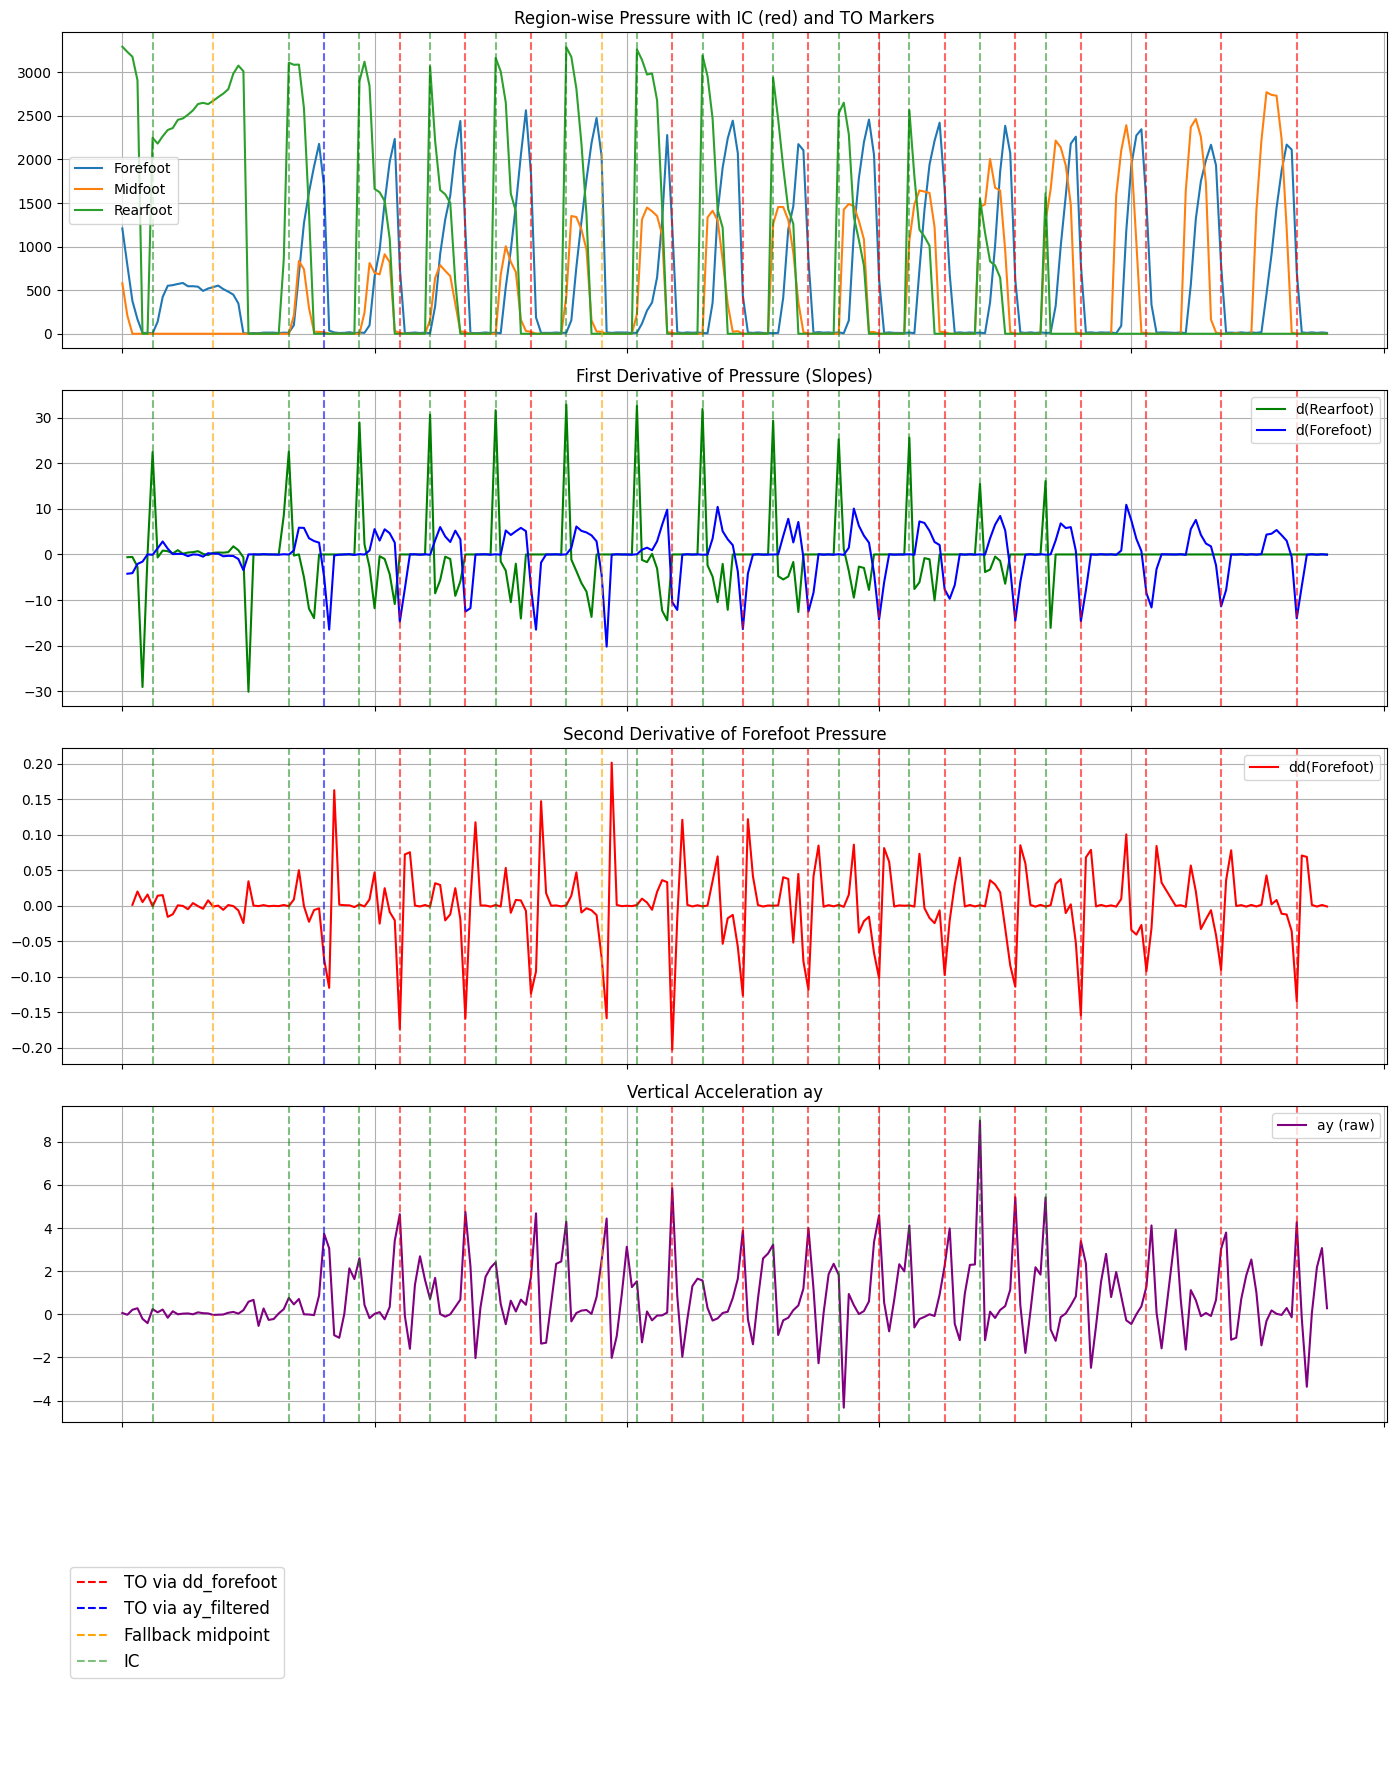

In [197]:
plot_ic_to(df_test, result["ic_times"], result["to_times"], result["to_labels"])


## Final Functions to Detect IC(Initial Contact) & TO (Toe Off)

In [294]:
import pandas as pd
from decimal import Decimal

def preprocess_sensor_dataframe(data):
    """
    Converts raw JSON data to a preprocessed DataFrame suitable for gait event detection.

    Steps:
    - Flattens JSON structure
    - Converts Decimal to float
    - Clips FSR values to [0, 4095]
    - Adds time_sec column (relative time)
    - Replaces FSR_14 with FSR_11 due to hardware wiring

    Returns:
        Preprocessed pandas DataFrame
    """
    # Convert to DataFrame and flatten JSON
    df = pd.json_normalize(data)

    # Convert Decimal to float
    df = df.map(lambda x: float(x) if isinstance(x, Decimal) else x)

    # Sort by timestamp
    df = df.sort_values(by="timestamp").reset_index(drop=True)

    # Ensure all FSR columns exist and clip values
    for i in range(1, 17):
        col = f"FSR_{i}"
        if col not in df.columns:
            df[col] = 0.0  # Fill missing columns with zeros
        df[col] = df[col].clip(0, 4095)

    # Replace FSR_14 with FSR_11 (due to hardware wiring)
    df["FSR_14"] = df["FSR_11"]

    # Create time_sec relative to session start
    df["time_sec"] = (df["timestamp"] - df["timestamp"].min() ) / 1000

    return df


In [295]:
def compute_region_averages(df):
    REGION_MAP = {
        "forefoot": [5, 6, 7, 8, 9, 12, 15, 16],
        "midfoot": [1, 2, 10, 11, 13, 14],
        "rearfoot": [3, 4]
    }
    for region, indices in REGION_MAP.items():
        sensor_cols = [f"FSR_{i}" for i in indices]
        df[region] = df[sensor_cols].mean(axis=1)
    return df


In [296]:
def compute_derivatives(df, time_col="time_sec"):
    df["d_rearfoot"] = df["rearfoot"].diff() / df[time_col].diff()
    df["d_forefoot"] = df["forefoot"].diff() / df[time_col].diff()
    df["dd_forefoot"] = df["d_forefoot"].diff() / df[time_col].diff()
    return df


Gait Event Detection

In [200]:
def detect_ic_to(df, time_col="time_sec"):
    df = df.copy()
    df = compute_region_averages(df)
    df = compute_derivatives(df, time_col)

    # --- Detect ICs ---
    ic_peaks, _ = find_peaks(df["d_rearfoot"], height=10, distance=5)
    ic_times = df[time_col].iloc[ic_peaks].to_list()

    # --- Detect TOs using raw ay and dd_forefoot ---
    forefoot_peaks, _ = find_peaks(df["forefoot"], height=500)
    ay_peaks, _ = find_peaks(df["ay"], height=2)
    dd_neg_peaks, _ = find_peaks(-df["dd_forefoot"], height=0.05)

    to_times = []
    to_labels = []

    for fp_idx in forefoot_peaks:
        after = df["forefoot"].iloc[fp_idx:].reset_index(drop=True)
        zero_cross = after[after < 100]
        if len(zero_cross) == 0:
            continue
        zc_idx = fp_idx + zero_cross.index[0]
        mid_idx = (fp_idx + zc_idx) // 2

        dd_peaks = [i for i in dd_neg_peaks if fp_idx < i < zc_idx]
        ay_peaks_in_range = [i for i in ay_peaks if fp_idx < i < zc_idx]

        if dd_peaks and ay_peaks_in_range:
            to_times.append(df[time_col].iloc[dd_peaks[0]])
            to_labels.append("dd")
        elif dd_peaks:
            to_times.append(df[time_col].iloc[dd_peaks[0]])
            to_labels.append("dd")
        elif ay_peaks_in_range:
            to_times.append(df[time_col].iloc[ay_peaks_in_range[0]])
            to_labels.append("ay")
        elif df["dd_forefoot"].iloc[mid_idx] < 0:
            to_times.append(df[time_col].iloc[mid_idx])
            to_labels.append("mid")

    return {
        "ic_times": ic_times,
        "to_times": to_times,
        "to_labels": to_labels
    }


In [201]:
import matplotlib.pyplot as plt

def plot_ic_to(df, ic_times, to_times, to_labels, time_col="time_sec"):
    # Colors for TO markers
    colors = {"dd": "red", "ay": "blue", "mid": "orange"}

    # Compute region-wise pressures and derivatives
    df = compute_region_averages(df)
    df = compute_derivatives(df, time_col)

    fig, axs = plt.subplots(5, 1, figsize=(14, 18), sharex=True)

    # 1. Region Pressure
    for region in ["forefoot", "midfoot", "rearfoot"]:
        axs[0].plot(df[time_col], df[region], label=region.capitalize())
    for t in ic_times:
        axs[0].axvline(x=t, color='green', linestyle='--', alpha=0.5)
    for t, lbl in zip(to_times, to_labels):
        axs[0].axvline(x=t, color=colors[lbl], linestyle='--', alpha=0.6)
    axs[0].set_title("Region-wise Pressure with IC (green) and TO Markers")
    axs[0].legend()
    axs[0].grid(True)

    # 2. d_rearfoot + d_forefoot
    axs[1].plot(df[time_col], df["d_rearfoot"], label="d(Rearfoot)", color="green")
    axs[1].plot(df[time_col], df["d_forefoot"], label="d(Forefoot)", color="blue")
    for t in ic_times:
        axs[1].axvline(x=t, color='green', linestyle='--', alpha=0.5)
    for t, lbl in zip(to_times, to_labels):
        axs[1].axvline(x=t, color=colors[lbl], linestyle='--', alpha=0.6)
    axs[1].set_title("First Derivative of Pressure (Slopes)")
    axs[1].legend()
    axs[1].grid(True)

    # 3. dd_forefoot
    axs[2].plot(df[time_col], df["dd_forefoot"], label="dd(Forefoot)", color="red")
    for t in ic_times:
        axs[2].axvline(x=t, color='green', linestyle='--', alpha=0.5)
    for t, lbl in zip(to_times, to_labels):
        axs[2].axvline(x=t, color=colors[lbl], linestyle='--', alpha=0.6)
    axs[2].set_title("Second Derivative of Forefoot Pressure")
    axs[2].legend()
    axs[2].grid(True)

    # 4. ay raw
    axs[3].plot(df[time_col], df["ay"], label="ay (raw)", color="purple")
    for t in ic_times:
        axs[3].axvline(x=t, color='green', linestyle='--', alpha=0.5)
    for t, lbl in zip(to_times, to_labels):
        axs[3].axvline(x=t, color=colors[lbl], linestyle='--', alpha=0.6)
    axs[3].set_title("Vertical Acceleration ay")
    axs[3].legend()
    axs[3].grid(True)

    # 5. Legend-only axis
    axs[4].axis('off')
    axs[4].legend(
        handles=[
            plt.Line2D([0], [0], color='red', linestyle='--', label='TO via dd_forefoot'),
            plt.Line2D([0], [0], color='blue', linestyle='--', label='TO via ay peak'),
            plt.Line2D([0], [0], color='orange', linestyle='--', label='Fallback midpoint'),
            plt.Line2D([0], [0], color='green', linestyle='--', alpha=0.5, label='IC'),
        ],
        loc='center left',
        fontsize=12
    )

    axs[-1].set_xlabel("Time (seconds)")
    plt.tight_layout()
    plt.show()


Example Usage


🔍 [DEBUG] Fetching data for Sensor ID: 601
🕒 [DEBUG] Start Time: 2025-05-31 23:09:16.722000 -> 1748713156722
🕒 [DEBUG] End Time:   2025-05-31 23:09:40.685000 -> 1748713180685
📦 [DEBUG] Retrieved 238 items from DynamoDB.

📦 Retrieved 238 records


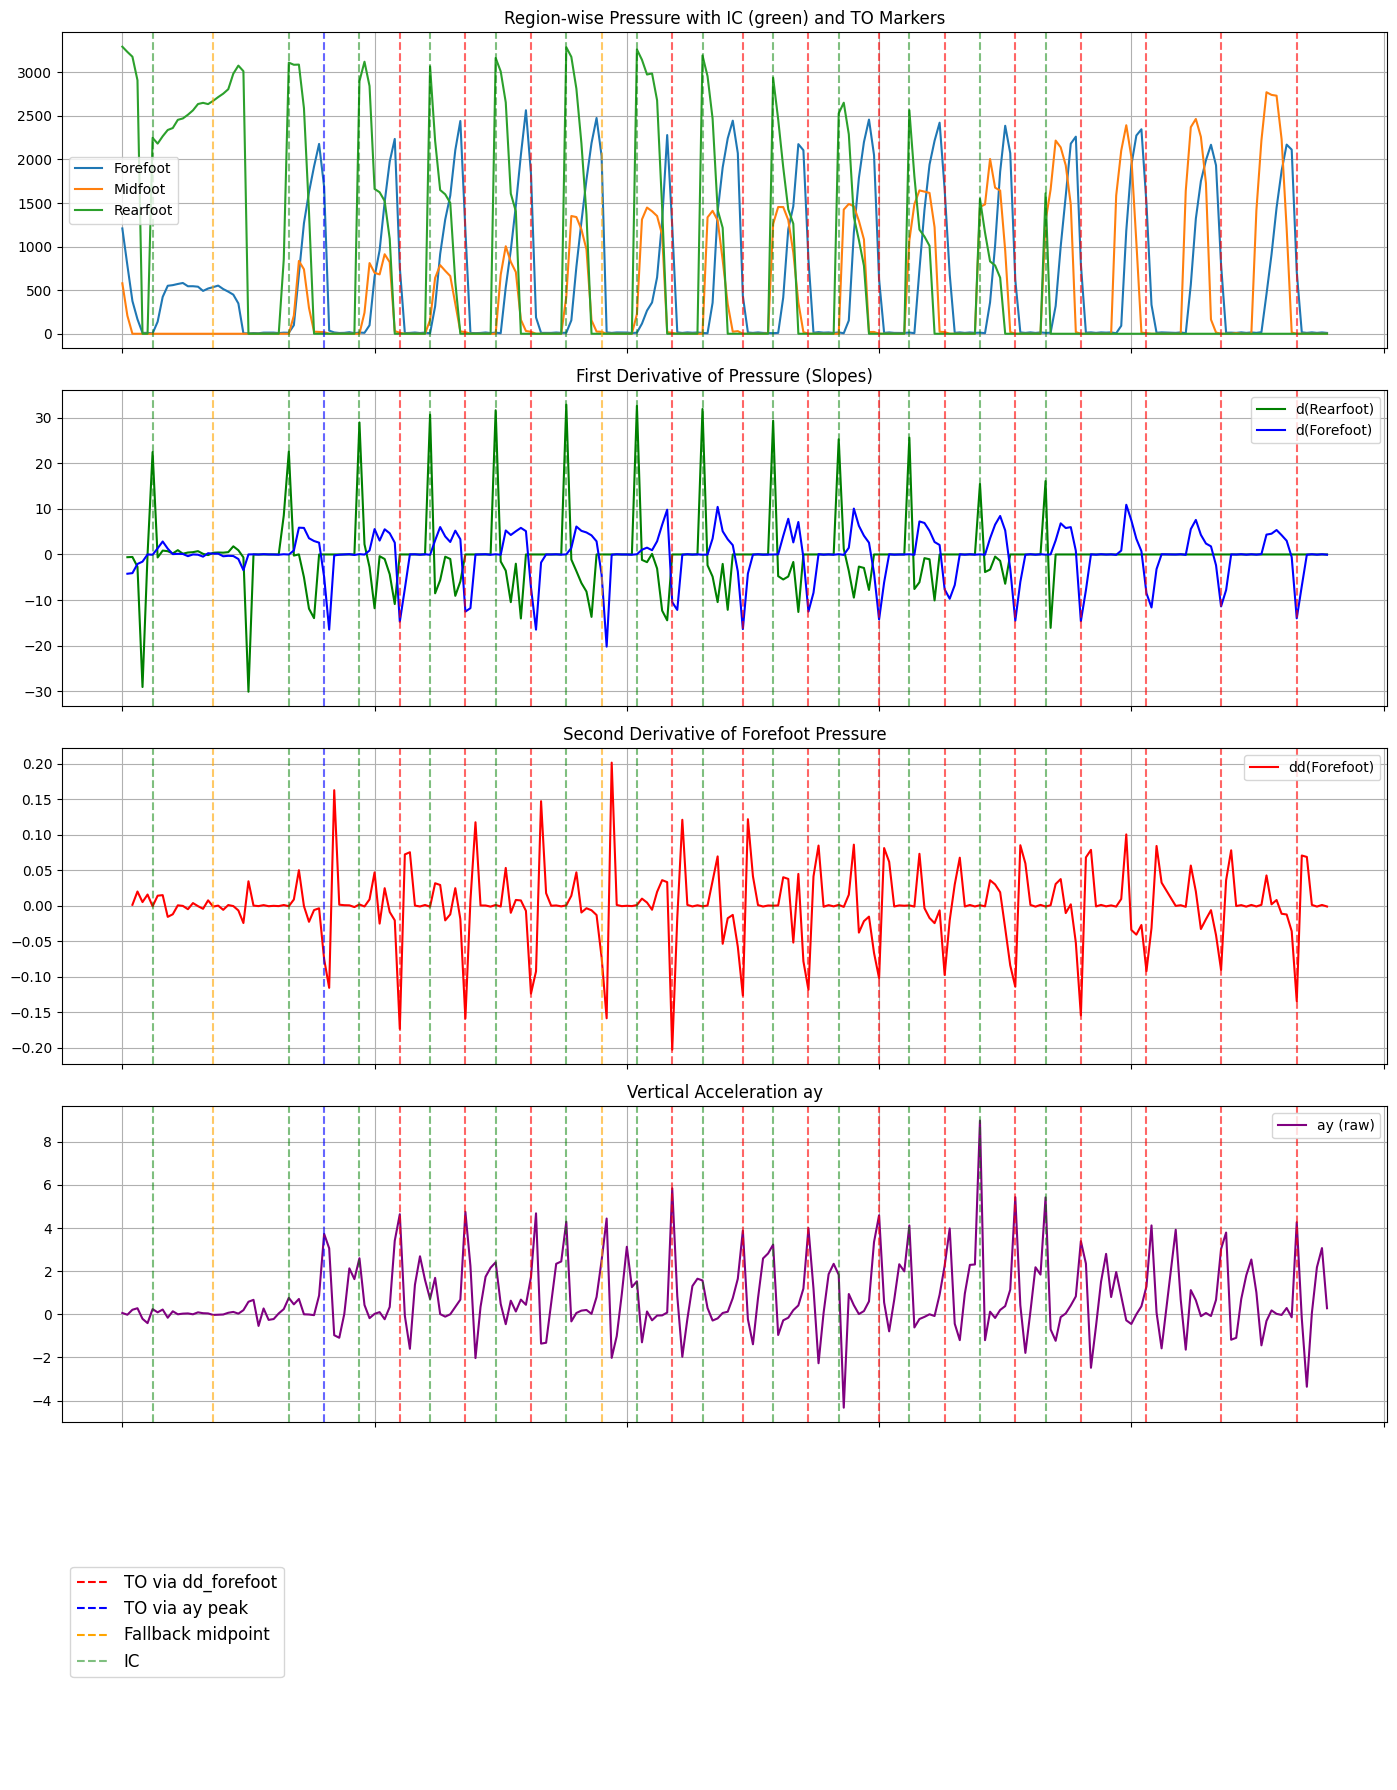

In [206]:

sensor_id = 601
start_time = datetime.fromisoformat("2025-05-31 23:09:16.722000")
end_time = datetime.fromisoformat("2025-05-31 23:09:40.685000")

data = fetch_session_data(sensor_id, start_time, end_time)
print(f"📦 Retrieved {len(data)} records")

df_to_process = preprocess_sensor_dataframe(data)

result = detect_ic_to(df_to_process)
plot_ic_to(df_to_process, result["ic_times"], result["to_times"], result["to_labels"])


Stride Time

In [211]:
import numpy as np

def compute_valid_stride_times(ic_times, multiplier=1.75):
    if len(ic_times) < 2:
        return [], []

    ic_intervals = np.diff(ic_times)
    median_stride = np.median(ic_intervals)
    upper_limit = multiplier * median_stride

    stride_times = []
    valid_ic_pairs = []

    for i, delta in enumerate(ic_intervals):
        if delta <= upper_limit:
            stride_times.append(delta)
            valid_ic_pairs.append((ic_times[i], ic_times[i+1]))

    return stride_times, valid_ic_pairs


In [226]:
stride_times, valid_ic_pairs = compute_valid_stride_times(result["ic_times"])

In [227]:
valid_ic_pairs

[(3300.0, 4700.0),
 (4700.0, 6100.0),
 (6100.0, 7400.0),
 (7400.0, 8800.0),
 (8800.0, 10200.0),
 (10200.0, 11500.0),
 (11500.0, 12900.0),
 (12900.0, 14200.0),
 (14200.0, 15600.0),
 (15600.0, 17000.0),
 (17000.0, 18300.0)]

In [214]:
stride_times

[np.float64(1400.0),
 np.float64(1400.0),
 np.float64(1300.0),
 np.float64(1400.0),
 np.float64(1400.0),
 np.float64(1300.0),
 np.float64(1400.0),
 np.float64(1300.0),
 np.float64(1400.0),
 np.float64(1400.0),
 np.float64(1300.0)]

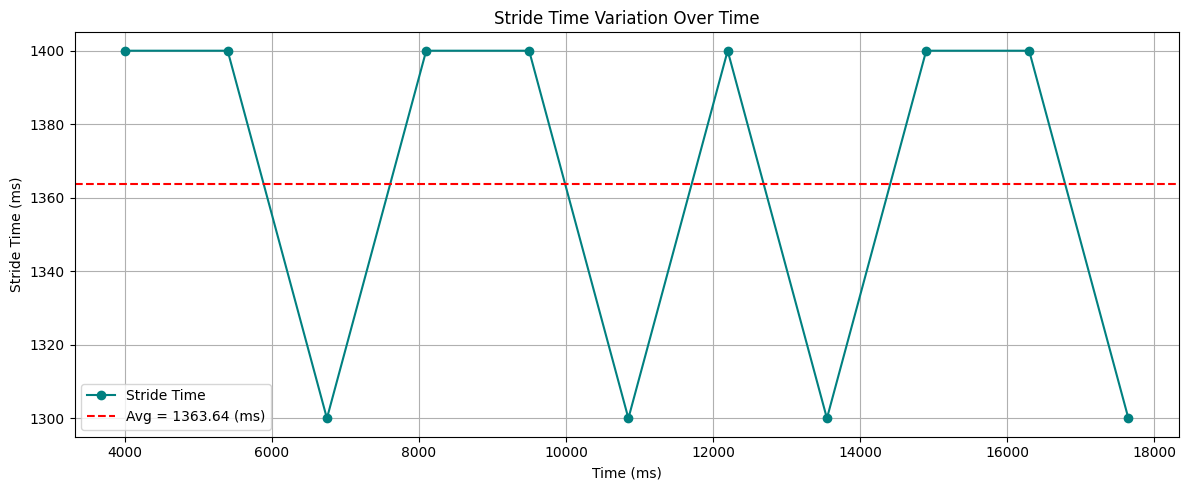

In [225]:
import matplotlib.pyplot as plt

def plot_stride_times(valid_ic_pairs, stride_times, title="Stride Time Variation Over Time", time_unit='ms'):
    if not valid_ic_pairs or not stride_times:
        print("⚠️ No valid stride data to plot.")
        return

    # Compute midpoints of stride windows for X-axis
    mid_times = [(start + end) / 2 for start, end in valid_ic_pairs]

    # Convert to seconds if needed
    if time_unit == 's':
        mid_times = [t / 1000.0 for t in mid_times]
        stride_times = [s / 1000.0 for s in stride_times]
        ylabel = "Stride Time (s)"
    else:
        ylabel = "Stride Time (ms)"

    # Compute average
    avg_stride = sum(stride_times) / len(stride_times)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(mid_times, stride_times, marker='o', linestyle='-', color='teal', label='Stride Time')
    plt.axhline(avg_stride, color='red', linestyle='--', label=f'Avg = {avg_stride:.2f} {ylabel.split()[2]}')
    plt.title(title)
    plt.xlabel("Time ({})".format("s" if time_unit == 's' else "ms"))
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_stride_times(valid_ic_pairs,stride_times)

In [224]:
stride_times_sec = [s / 1000.0 for s in stride_times]
avg_stride_time = np.mean(stride_times_sec)
print(f"✅ Average Stride Time: {avg_stride_time:.2f} seconds")

stride_time_std = np.std(stride_times_sec)
print(f"✅Stride Time Standard Deviation: {stride_time_std:.2f} seconds")

✅ Average Stride Time: 1.36 seconds
✅Stride Time Standard Deviation: 0.05 seconds


Step Count

In [ ]:
def count_steps_from_events(ic_times, to_times, max_gap=2.0):
    """
    Enhanced hybrid step counting:
    - Counts IC→TO always
    - Counts TO→TO and IC→IC if time gap is safe
    - Avoids double counting
    """
    # Merge and sort all events
    events = sorted(
        [{'time': t, 'type': 'IC'} for t in ic_times] +
        [{'time': t, 'type': 'TO'} for t in to_times],
        key=lambda x: x['time']
    )

    steps = []
    i = 0
    while i < len(events) - 1:
        curr = events[i]
        nxt = events[i + 1]
        gap = (nxt['time'] - curr['time'] )  # gap in seconds

        if curr['type'] == 'IC' and nxt['type'] == 'TO':
            # Always count IC→TO
            steps.append((curr['time'], nxt['time'], 'IC→TO'))
            i += 1  # Move only one step forward to check next TO pairing
        elif curr['type'] == nxt['type'] and gap <= max_gap:
            # Count same-type events if safe
            steps.append((curr['time'], nxt['time'], f'{curr["type"]}→{nxt["type"]}'))
            i += 1  # Still only move one step
        i += 1  # Move to next event

    return len(steps), steps


In [283]:
step_count, step_list = count_steps_from_events(result["ic_times"], result["to_times"])
print("Step Count:", step_count)

for s in step_list:
    print(f"Step: {s[2]} from {s[0]:.2f}ms to {s[1]:.2f}ms")



Step Count: 14
Step: IC→TO from 600.00ms to 1800.00ms
Step: IC→TO from 3300.00ms to 4000.00ms
Step: IC→TO from 4700.00ms to 5500.00ms
Step: IC→TO from 6100.00ms to 6800.00ms
Step: IC→TO from 7400.00ms to 8100.00ms
Step: IC→TO from 8800.00ms to 9500.00ms
Step: IC→TO from 10200.00ms to 10900.00ms
Step: IC→TO from 11500.00ms to 12300.00ms
Step: IC→TO from 12900.00ms to 13600.00ms
Step: IC→TO from 14200.00ms to 15000.00ms
Step: IC→TO from 15600.00ms to 16300.00ms
Step: IC→TO from 17000.00ms to 17700.00ms
Step: IC→TO from 18300.00ms to 19000.00ms
Step: TO→TO from 20300.00ms to 21779.00ms


cadence

In [ ]:
def calculate_cadence(steps):
    """
    Calculate average cadence in steps per minute.
    steps: list of (start_time, end_time, type)
    """
    if len(steps) < 2:
        return 0  # Not enough data

    # Convert ms timestamps to seconds
    start_time = steps[0][0] 
    end_time = steps[-1][1] 
    duration_min = (end_time - start_time) / 60

    if duration_min <= 0:
        return 0

    cadence = len(steps) / duration_min
    return round(cadence, 2)


In [293]:
step_count, steps = count_steps_from_events(result["ic_times"], result["to_times"])
cadence = calculate_cadence(steps)
print(f"👣 Total Steps: {step_count}")
print(f"🎵 Average Cadence: {cadence} steps/min")


👣 Total Steps: 14
🎵 Average Cadence: 39.66 steps/min


### Stride Length

Let's implement a basic stride length estimator using your ax values (linear acceleration in m/s²) and IC timestamps, assuming:

Gravity is already removed (thanks to BNO055's VECTOR_LINEARACCEL).

Forward motion is aligned with the X-axis (ax).

Time is in milliseconds.

We'll use numerical integration (trapezoidal rule) over each IC → next IC interval.